<h1>
🐝 Projet ML/IA - 'To bee or not to bee'

<h3>1. Imports & Configuration

In [1]:
# 📦 Imports
from tqdm import tqdm_notebook as tqdm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from collections import Counter
from skimage.io import imread, imsave
from skimage.measure import regionprops, label, moments_hu
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import rotate
from skimage.util import img_as_ubyte
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from scipy.ndimage import distance_transform_edt
from scipy.optimize import minimize
from scipy.stats import uniform, randint, loguniform
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8')

<h3>2. Load data and setup paths

In [2]:
# 📁 Initializing folder paths and filenames

image_dir = 'train/'
mask_dir = 'train/masks/'
cropped_dir = 'cropped/'
cropped_masks_dir = 'cropped/masks/'
inscribed_circles_dir = 'circles/'
symmetry_axes_dir = 'symmetry_axes/'
test_image_dir = 'test/'  # For images 251-347
test_mask_dir = 'test/masks/'
extracted_features_file = 'extracted_features.csv'

<font color='yellow'><h5> Load data and display basic stats

In [3]:
# Raw dataset visualization

try:
    label_df = pd.read_excel('classif.xlsx')
    print("Classification file loaded successfully")
    print(f"Number of training samples: {len(label_df)}")
    print("\nBug type distribution:")
    print(label_df['bug type'].value_counts())
    print("\nSpecies distribution:")
    print(label_df['species'].value_counts())
except Exception as e:
    print(f"Error loading classification file: {e}")

Classification file loaded successfully
Number of training samples: 250

Bug type distribution:
bug type
Bee                115
Bumblebee          100
Butterfly           15
Hover fly            9
Wasp                 9
Dragonfly            1
Bee & Bumblebee      1
Name: count, dtype: int64

Species distribution:
species
Bombus hortorum                              71
Apis mellifera                               58
Bombus pascuorum                             25
Anthidium manicatum                          19
Megachile centuncularis                      17
Eristalis                                     9
Vespula germanica                             8
Anthidium                                     6
Macroglossum stellatarum                      5
Andrenidae                                    4
Pieris rapae                                  4
Aglais urticae                                3
Thyreus                                       3
Polyommatus icarus                            2
Bombu

<h3>3. Mask Pre-Processing and Feature Extraction Functions

In [4]:
# Features extraction functions
def preprocess_mask(mask_path, image_path=None, save_id=None):
    """
    Clean mask and crop iamge and mask to the bounding box
    """
    mask = imread(mask_path, as_gray=True) > 0
    labeled = label(mask)
    props = regionprops(labeled)

    if not props:
        return None, None

    largest = max(props, key=lambda x: x.area)
    clean_mask = labeled == largest.label
    minr, minc, maxr, maxc = largest.bbox
    cropped_mask = clean_mask[minr:maxr, minc:maxc]

    if image_path:
        image = imread(image_path)
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        cropped_image = image[minr:maxr, minc:maxc]
    else:
        cropped_image = None
        
    if save_id is not None:
        imsave(f'{cropped_masks_dir}cropped_mask_{save_id}.png', img_as_ubyte(cropped_mask.astype(bool)))
        if cropped_image is not None:
            imsave(f'{cropped_dir}cropped_image_{save_id}.png', img_as_ubyte(cropped_image))

    return cropped_mask, cropped_image

def find_best_inscribed_circle(binary_mask):
    """
    Return x, y and radius of the largest inscribed cricle in the mask.
    """
    if np.sum(binary_mask) == 0:
        return 0, 0, 0  # masque vide

    labeled_mask = label(binary_mask)
    props = regionprops(labeled_mask)

    if not props:
        return 0, 0, 0  # aucune région détectée

    # Choisir la plus grande région connectée
    main_region = max(props, key=lambda p: p.area)
    centroid = np.array(main_region.centroid)

    distance = distance_transform_edt(binary_mask)

    def neg_radius(params):
        x, y = params
        ix, iy = int(x), int(y)
        if 0 <= iy < distance.shape[0] and 0 <= ix < distance.shape[1]:
            return -distance[iy, ix]
        return 1e6  # pénaliser les positions hors du masque

    try:
        result = minimize(neg_radius, x0=centroid[::-1],
                          bounds=[(0, binary_mask.shape[1]), (0, binary_mask.shape[0])])
        if result.success:
            best_x, best_y = result.x
            best_radius = distance[int(best_y), int(best_x)]
            return best_x, best_y, best_radius
        else:
            return 0, 0, 0  # optimisation échouée
    except:
        return 0, 0, 0  # sécurité ultime

def create_circular_mask(shape, center, radius):
    """
    Xreate a mask based on the associated inscribed circle
    """
    h, w = shape
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    return dist_from_center <= radius

def save_inscribed_circle_overlay(image, center_x, center_y, radius, save_path):
    """
    Draw and save inscribed cricle
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image)
    circle = Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def vertical_symmetry_loss(angle, image, xc, yc, mask=None):
    angle = float(angle)  
    rotated = rotate(image, angle, resize=False, center=(xc, yc), preserve_range=True)
    flipped = rotated[:, ::-1, ...]
    difference = (rotated - flipped) ** 2
    if mask is not None:
        mask_rot = rotate(mask.astype(float), angle, resize=False, center=(xc, yc), preserve_range=True)
        return np.mean(difference[mask_rot > 0.5])
    return np.mean(difference)

def find_best_symmetry_angle(image, center_x, center_y, mask=None):
    result = minimize(vertical_symmetry_loss, x0=0, args=(image, center_x, center_y, mask), bounds=[(-45, 45)])
    return result.x[0]

def save_symmetry_axis_overlay(image, center_x, center_y, angle, save_path):
    """
    DIsplay and saves the symmetry axis of the image
    """
    rotated = rotate(image, angle, resize=False, center=(center_x, center_y), preserve_range=True)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(rotated.astype(np.uint8))
    ax.axvline(center_x, color='cyan', linestyle='--', linewidth=2, label="Symmetry Axis")
    ax.set_title(f"Symmetry axis at angle {angle:.2f}°")
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def extract_comprehensive_features(image_path, mask_path, img_id=None):
    """
    Extract images / mask features.
    Project requirements and personnal additions
    """
    try:
        # REQUIRED : Load cropped image and mask
        mask, image = preprocess_mask(mask_path, image_path, img_id)
        if mask is None or image is None:
            return None
        
        # Ensure image is 3D (RGB)
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=2)
        
        # Get region properties
        labeled_mask = label(mask.astype(int))
        props = regionprops(labeled_mask)
        
        features = {}
        
        # REQUIRED: Inscribed circle
        try:
            cx, cy, radius = find_best_inscribed_circle(mask)
            features['inscribed_circle_radius'] = radius
            circle_path = f'{inscribed_circles_dir}circle_{img_id}.png'
            save_inscribed_circle_overlay(image, cx, cy, radius, circle_path)
        except:
            features['inscribed_circle_radius'] = 0
        """
        # REQUIRED: Vertical symetry
        try:
            symmetry_angle = find_best_symmetry_angle(image, cx, cy, mask)
            features['symmetry_angle'] = symmetry_angle
            symmetry_path = f'{symmetry_axes_dir}symmetry_{img_id}.png'
            save_symmetry_axis_overlay(image, cx, cy, symmetry_angle, symmetry_path)
        except Exception as e:
            print(f"[ERROR] Failed to compute symmetry for ID {img_id}: {e}")
            features['symmetry_angle'] = 0
        """
        # REQUIRED: Area ratio (pixels of bug / pixels of full image)
        total_pixels = mask.shape[0] * mask.shape[1]
        bug_pixels = np.sum(mask)
        features['area'] = bug_pixels
        features['area_ratio'] = bug_pixels / total_pixels
        
        # REQUIRED: RGB statistics within bug mask
        for i, color in enumerate(['R', 'G', 'B']):
            if image.shape[2] > i:
                channel = image[:, :, i]
                values = channel[mask]
                if len(values) > 0:
                    features[f'{color}_min'] = np.min(values)
                    features[f'{color}_max'] = np.max(values)
                    features[f'{color}_mean'] = np.mean(values)
                    features[f'{color}_median'] = np.median(values)
                    features[f'{color}_std'] = np.std(values)
                else:
                    # Handle empty mask case
                    for stat in ['min', 'max', 'mean', 'median', 'std']:
                        features[f'{color}_{stat}'] = 0
                        
        # ADDITIONAL: RGB statistics within inscibed circle mask
        circle_mask = create_circular_mask(mask.shape, (cx, cy), radius)
        for i, (color, stat) in enumerate([('R', 'mean'),('G', 'std'),('B', 'median')]):
            if image.shape[2] > i:
                channel = image[:, :, i]
                values = channel[circle_mask]
                if len(values):
                    if stat == 'mean':
                        features[f'circle_{color}_{stat}'] = np.mean(values)
                    elif stat == 'std':
                        features[f'circle_{color}_{stat}'] = np.std(values)
                    elif stat == 'median':
                        features[f'circle_{color}_{stat}'] = np.median(values)
                else:
                    features[f'circle_{color}_{stat}'] = 0
            
        # ADDITIONAL: Shape and symmetry measures features
        if props:
            prop = props[0]  # Take the largest connected component

            features['aspect_ratio'] = prop.major_axis_length / max(prop.minor_axis_length, 1e-6)
            features['eccentricity'] = prop.eccentricity
            features['compactness'] = (prop.perimeter ** 2) / max(prop.area, 1e-6)
            features['roundness'] = (4 * np.pi * prop.area) / max(prop.perimeter ** 2, 1e-6)
            features['orientation'] = prop.orientation
            features['solidity'] = prop.solidity
            features['permieter'] = prop.perimeter
            features['extent'] = prop.extent
            
        else:
            # Default values if no region found
            shape_features = ['eccentricity', 'solidity', 'aspect_ratio', 'compactness', 'roundness', 'orientation']
            for feat in shape_features:
                features[feat] = 0
                
        # ADDITIONAL: Other features
        # Edge Density
        try:
            gray_image = np.mean(image, axis=2).astype(np.uint8)
            edges = sobel(gray_image)
            features['edge_density'] = np.sum(edges[mask]) / max(np.sum(mask), 1)
        except:
            features['edge_density'] = 0

        # Texture (GLCM)
        try:
            gray_image = np.mean(image, axis=2).astype(np.uint8)
            region = gray_image * mask
            region_quant = (region / 255 * 32).astype(np.uint8)
            glcm = graycomatrix(region_quant, [1], [0], levels=32, symmetric=True, normed=True)
            features['glcm_homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
            features['glcm_energy'] = graycoprops(glcm, 'energy')[0, 0]
        except:
            for feat in ['homogeneity', 'energy']:
                features[f'glcm_{feat}'] = 0
       
        # Body wings ratio
        try:
            mask_area = np.sum(mask)  # zone du bug
            circle_area = np.pi * (features['inscribed_circle_radius'] ** 2)
            if circle_area > 0:
                features['wings_body_ratio'] = (mask_area - circle_area) / circle_area
            else:
                features['wings_body_ratio'] = 0 
        except:
            features['wings_body_ratio'] = 0
        
        # Intensity on central axe (stripe detection ?)
        try:
            strip_width = 5
            x_start = int(max(0, cx - strip_width))
            x_end = int(min(image.shape[1], cx + strip_width))

            central_strip = image[:, x_start:x_end, :]  

            if central_strip.size > 0 and x_end > x_start:
                central_std = np.std(central_strip, axis=(0, 1))
                features['central_rgb_variation'] = np.mean(central_std)
            else:
                features['central_rgb_variation'] = 0  # fallback
        except:
            features['central_rgb_variation'] = 0
        
        return features
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

<h3>4. Extract features from training set</h3>

<font color='yellow'><h5>a) Extracting process

In [5]:
# Feature extraction block - Taking from csv if exists, otherwise extracting from images

print("Extracting features from training images...")
feature_list = []
failed_extractions = []

# If feature sets already exists in a csv file, load them instead of extracting from scratch
if os.path.exists(extracted_features_file):
    print(f"Loading existing features from {extracted_features_file}")
    feature_list = pd.read_csv(extracted_features_file).to_dict(orient='records')

else:
    print("No existing features found, extracting from scratch.")
    for i, row in label_df.iterrows():
        img_id = row['ID']
        img_path = os.path.join(image_dir, f"{img_id}.JPG")
        mask_path = os.path.join(mask_dir, f"binary_{img_id}.tif")
        
        # We make sure to check if image and mask exist for each ID
        try:
            if not os.path.exists(img_path):
                print(f"[WARNING] Image missing: {img_path}")
                failed_extractions.append(img_id)
                continue
            if not os.path.exists(mask_path):
                print(f"[WARNING] Mask missing: {mask_path}")
                failed_extractions.append(img_id)
                continue
            
            features = extract_comprehensive_features(img_path, mask_path, img_id)
            if features is not None:
                features['ID'] = img_id
                features['bug_type'] = row['bug type']
                features['species'] = row['species']
                feature_list.append(features)
            else:
                failed_extractions.append(img_id)
                
        except Exception as e:
            print(f"[ERROR] Problem with ID {img_id}: {e}")
            failed_extractions.append(img_id)

Extracting features from training images...
Loading existing features from extracted_features.csv


<font color='yellow'><h5>b) Storing extracted features into a pandas dataframe and extracting into csv format

In [6]:
# Save data as a panda Dataframe
df_features = pd.DataFrame(feature_list)

# Display extraction summary
print(f"\nFeature extraction completed!")
print(f"Successfully processed: {len(df_features)} images")
print(f"Failed extractions: {len(failed_extractions)} images")
print(f"Feature dimensions: {df_features.shape}")

# Display basic statistics
print("\n=== FEATURE SUMMARY ===")

feature_cols = [col for col in df_features.columns if col not in ['ID', 'bug_type', 'species']]

print(f"Total features extracted: {len(feature_cols)}")
print("\nFeature list:")
for i, feat in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feat}")

# Save features to CSV 
df_features.to_csv('extracted_features.csv', index=False)
print("\nFeatures saved to 'extracted_features.csv'")

print("\n=== SAMPLE DATA ===")
print(df_features.head())


Feature extraction completed!
Successfully processed: 249 images
Failed extractions: 0 images
Feature dimensions: (249, 37)

=== FEATURE SUMMARY ===
Total features extracted: 34

Feature list:
 1. inscribed_circle_radius
 2. area
 3. area_ratio
 4. R_min
 5. R_max
 6. R_mean
 7. R_median
 8. R_std
 9. G_min
10. G_max
11. G_mean
12. G_median
13. G_std
14. B_min
15. B_max
16. B_mean
17. B_median
18. B_std
19. circle_R_mean
20. circle_G_std
21. circle_B_median
22. aspect_ratio
23. eccentricity
24. compactness
25. roundness
26. orientation
27. solidity
28. permieter
29. extent
30. edge_density
31. glcm_homogeneity
32. glcm_energy
33. wings_body_ratio
34. central_rgb_variation

Features saved to 'extracted_features.csv'

=== SAMPLE DATA ===
   inscribed_circle_radius    area  area_ratio  R_min  R_max      R_mean  \
0               128.128841  178109    0.506544      5    208   68.047510   
1               109.658561  205068    0.431831      2    248   63.721829   
2               179.17589

<h3>5. Dataset visualization and preparation

<font color='yellow'><h5> a) Bugs and species distribution

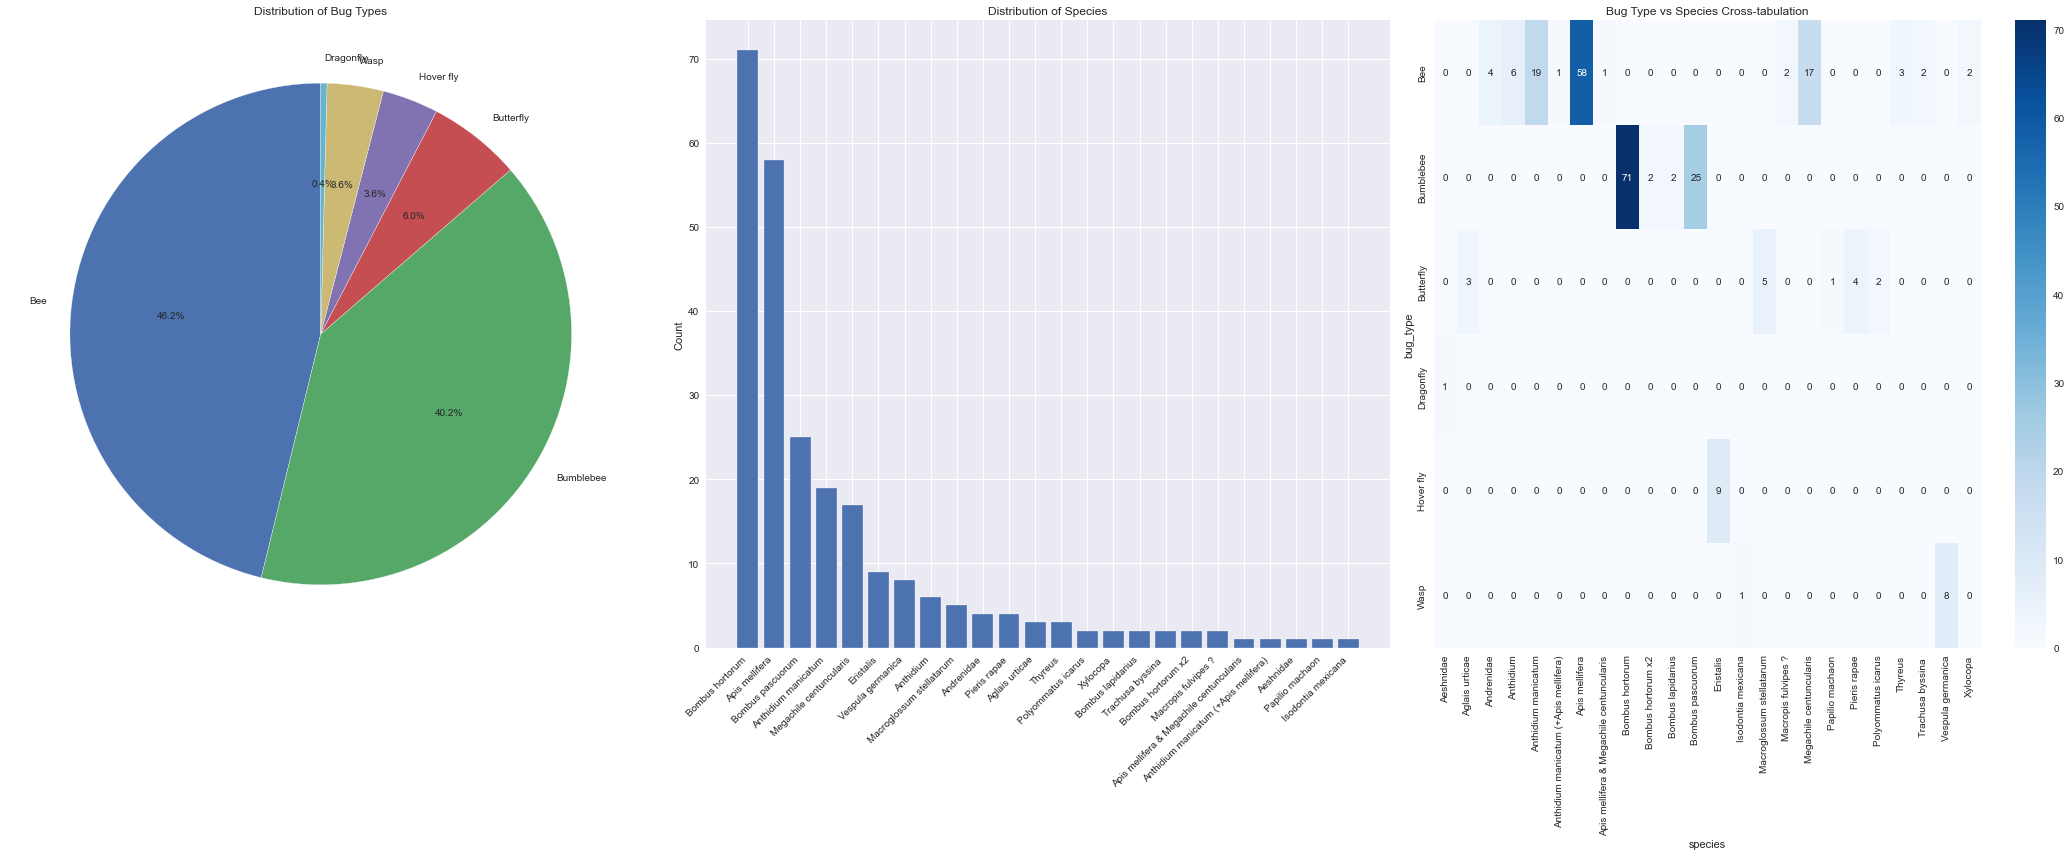

In [7]:
# Plotting data distributions
plt.figure(figsize=(30, 12))

plt.subplot(1, 3, 1)
bug_counts = df_features['bug_type'].value_counts()
plt.pie(bug_counts.values, labels=bug_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Bug Types')

plt.subplot(1, 3, 2)
species_counts = df_features['species'].value_counts()
plt.bar(range(len(species_counts)), species_counts.values)
plt.xticks(range(len(species_counts)), species_counts.index, rotation=45, ha='right')
plt.title('Distribution of Species')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
# Cross-tabulation
ct = pd.crosstab(df_features['bug_type'], df_features['species'])
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title('Bug Type vs Species Cross-tabulation')

plt.tight_layout()
plt.show()

<font color='yellow'><h5> b) Bugs type reduction

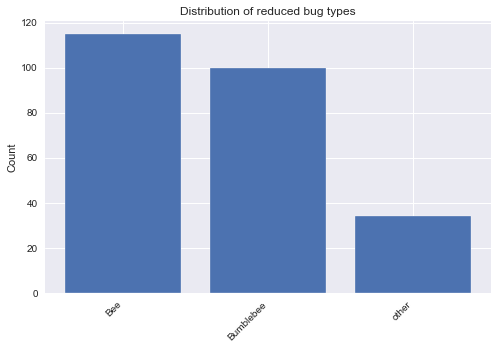

In [8]:
# We will also work with a subset of bug types grouping every small classes 
df_features["reduced_bug_type"] = df_features["bug_type"].apply(lambda x: x if x in ["Bee", "Bumblebee"] else "other")

plt.figure(figsize=(8, 5))
species_counts = df_features['reduced_bug_type'].value_counts()
plt.bar(range(len(species_counts)), species_counts.values)
plt.xticks(range(len(species_counts)), species_counts.index, rotation=45, ha='right')
plt.title('Distribution of reduced bug types')
plt.ylabel('Count')

plt.show()

<font color='yellow'><h5>c) Features visualization

In [9]:
# Load the features that were previously extracted
df = df_features.copy()   # Copy to avoid modifying the original DataFrame

# Show all available columns (features + metadata)
print("All features in the dataset:")
print(df.columns.tolist())

# Keep only feature columns (remove ID and labels)
X = df[feature_cols]

All features in the dataset:
['inscribed_circle_radius', 'area', 'area_ratio', 'R_min', 'R_max', 'R_mean', 'R_median', 'R_std', 'G_min', 'G_max', 'G_mean', 'G_median', 'G_std', 'B_min', 'B_max', 'B_mean', 'B_median', 'B_std', 'circle_R_mean', 'circle_G_std', 'circle_B_median', 'aspect_ratio', 'eccentricity', 'compactness', 'roundness', 'orientation', 'solidity', 'permieter', 'extent', 'edge_density', 'glcm_homogeneity', 'glcm_energy', 'wings_body_ratio', 'central_rgb_variation', 'ID', 'bug_type', 'species', 'reduced_bug_type']


In [10]:
# Checking features that could have bad values
# possible NaN values :
nan_rows = df[df['central_rgb_variation'].isna()]
print("Images avec NaN dans 'central_rgb_variation':")
print(nan_rows[['ID', 'central_rgb_variation']])

# possible inf values :
inf_rows = df[np.isinf(df['wings_body_ratio'])]
print("\nImages avec Inf dans 'wings_body_ratio':")
print(inf_rows[['ID', 'wings_body_ratio']])


Images avec NaN dans 'central_rgb_variation':
Empty DataFrame
Columns: [ID, central_rgb_variation]
Index: []

Images avec Inf dans 'wings_body_ratio':
Empty DataFrame
Columns: [ID, wings_body_ratio]
Index: []


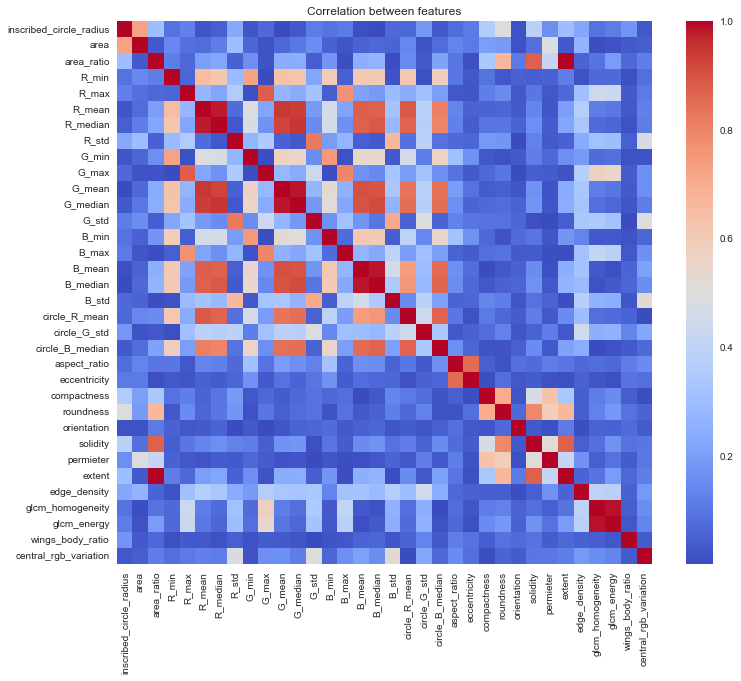

In [11]:
# Calculate absolute correlation between features
corr_matrix = X.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation between features")
plt.show()


<font color='yellow'><h5>d) Filtering features with high correlation

In [12]:
# Drop one of each pair of features with correlation > 0.95
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

print(f"\nHighly correlated features (to be removed): {to_drop}")

# Manually selecting the features from the detected pairs (and more) 
to_drop_manual = ['glcm_homogeneity', 'R_max', 'G_max', 'B_max', 'R_std', 'G_std', 'B_std','extent', 'solidity']


Highly correlated features (to be removed): ['R_median', 'G_median', 'B_median', 'extent', 'glcm_energy']


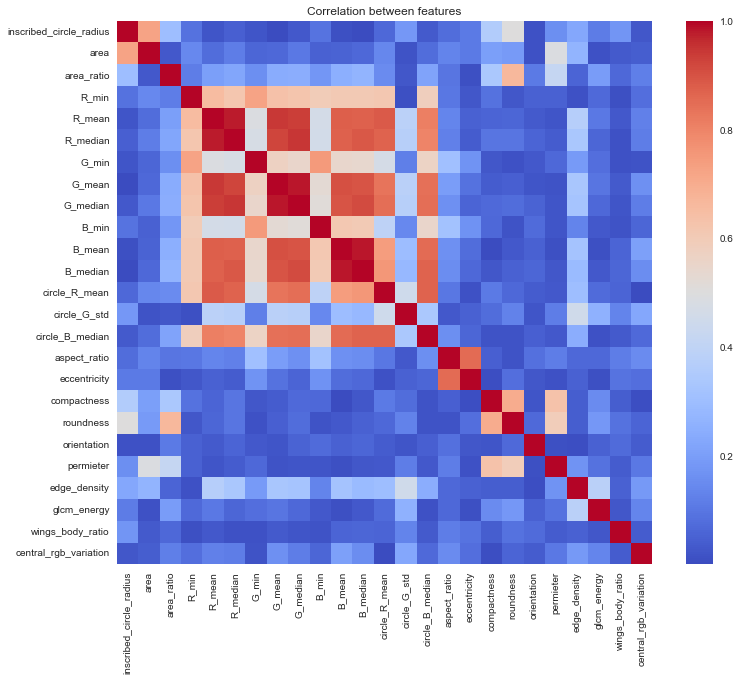

In [13]:
# Compute new correlation matrice
X_filtered = X.drop(columns=to_drop_manual)  
corr_matrix = X_filtered.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation between features")
plt.show()

<font color='yellow'><h5>d) comparing full sets performances with basic RF

In [14]:
# Running RF on both feature sets for both class targets

y = df['bug_type']
y2 = df['reduced_bug_type']

sets = [X, X_filtered]
targets = [y, y2]

results = {}

for i, (X_set, y_set) in enumerate([(s, t) for s in sets for t in targets]):
    print(f"\n=== Running Random Forest on Feature Set {i+1} ===")
    print(f"Feature set shape: {X_set.shape[1]} features")
    print(f"Target classes {y_set.name}")
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_set)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_set, test_size=0.2, random_state=42)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    
    # Evaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Feature importance from Random Forest
    feature_importance_rf = rf.feature_importances_
    top_features_rf_idx = np.argsort(feature_importance_rf)[-40:]
    top_features_rf = [X_set.columns.tolist()[i] for i in top_features_rf_idx]
    
    # Storing RF results for plots
    results[f'feature_set_{i+1}'] = (y_test, y_pred, feature_importance_rf, top_features_rf, top_features_rf_idx)



=== Running Random Forest on Feature Set 1 ===
Feature set shape: 34 features
Target classes bug_type
Accuracy: 0.64
Balanced Accuracy: 0.37333333333333335
              precision    recall  f1-score   support

         Bee       0.72      0.70      0.71        30
   Bumblebee       0.50      0.67      0.57        15
   Butterfly       1.00      0.50      0.67         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.64        50
   macro avg       0.44      0.37      0.39        50
weighted avg       0.62      0.64      0.63        50


=== Running Random Forest on Feature Set 2 ===
Feature set shape: 34 features
Target classes reduced_bug_type
Accuracy: 0.66
Balanced Accuracy: 0.5444444444444444
              precision    recall  f1-score   support

         Bee       0.75      0.70      0.72        30
   Bumblebee       0.52      0.73      0.61        15
       other       1.00    


=== Confusion Matrices ===


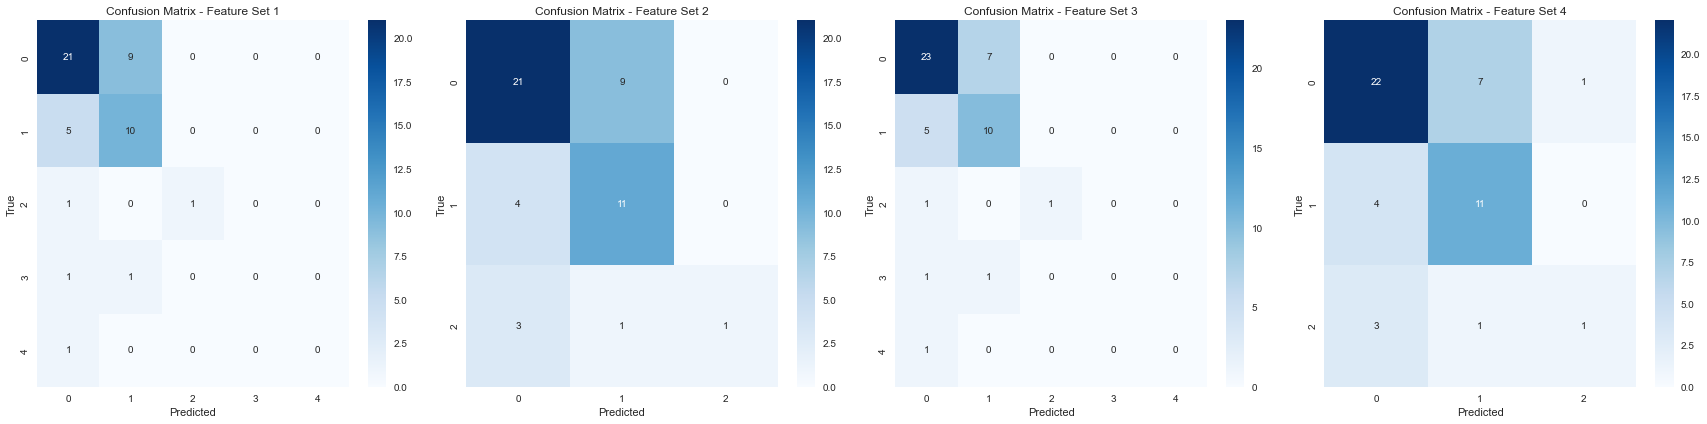


=== Feature Importances ===


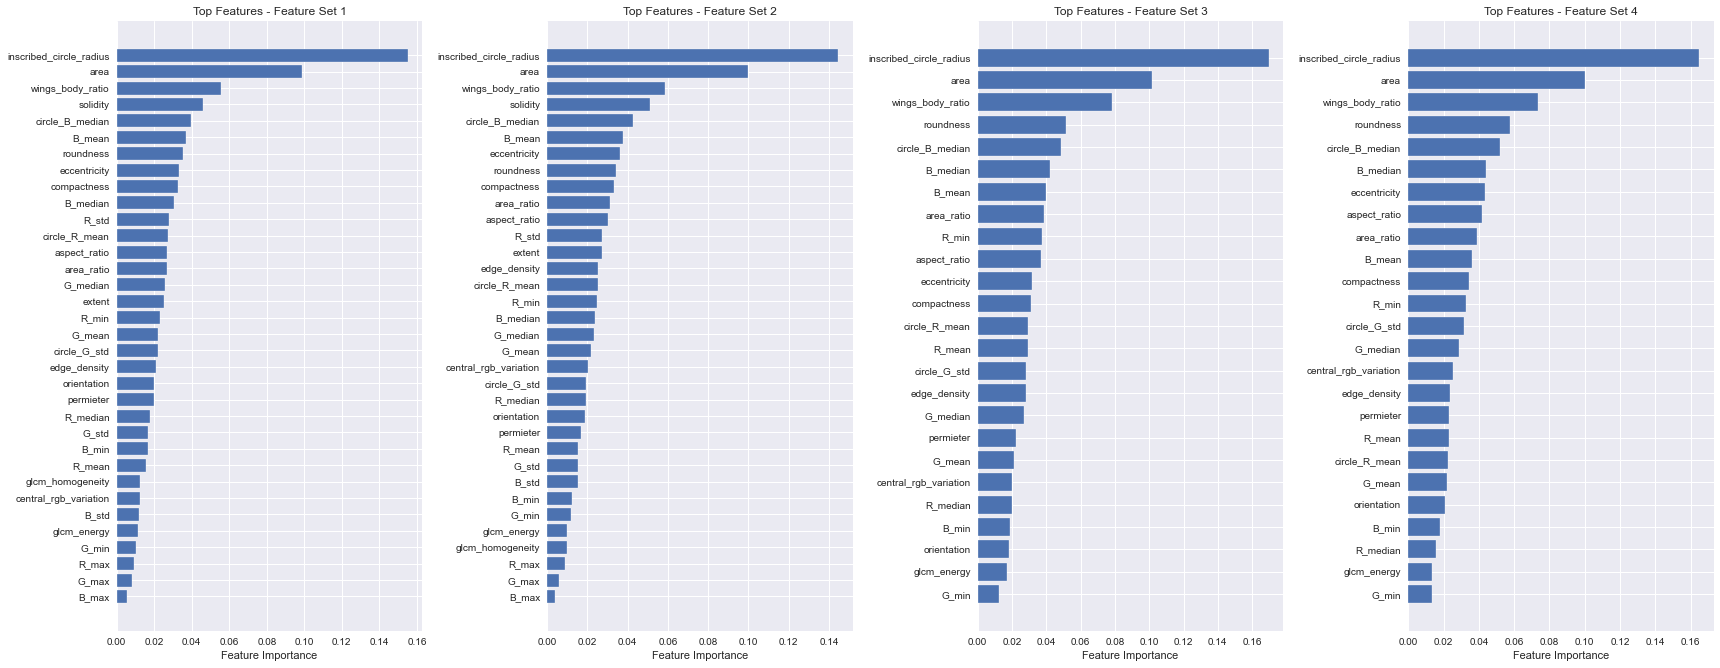

In [15]:
# Plotting confusion matrices
print("\n=== Confusion Matrices ===")
plt.figure(figsize=(24, 6))
for i, (y_test, y_pred, feature_importance_rf, top_features_rf, top_features_rf_idx) in enumerate(results.values()):
    
    plt.subplot(1, len(results), i + 1)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Feature Set {i + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
plt.tight_layout()
plt.show()

# Plotting feature importance
print("\n=== Feature Importances ===")
plt.figure(figsize=(24, 18))
for i, (y_test, y_pred, feature_importance_rf, top_features_rf, top_features_rf_idx) in enumerate(results.values()):
    
    plt.subplot(2, len(results), i + 1)
    plt.barh(range(len(top_features_rf)), feature_importance_rf[top_features_rf_idx])
    plt.yticks(range(len(top_features_rf)), top_features_rf)
    plt.xlabel('Feature Importance')
    plt.title(f'Top Features - Feature Set {i + 1}')
    
plt.tight_layout()
plt.show()


<font color='yellow'><h5>e) PCA Projections 

In [16]:
# PCA function in order to run it on multiple feature / classes combinations
def run_pca(X, y):
    
    print("=== Running PCA ===")
    print(f"Number of features: {X.shape[1]}")
    print(f"Targetted classes: {y.name}")
    
    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Model preparation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"PCA Variance explained by first 2 components: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")
    
    # Plotting PCA results
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    classes = sorted(y.unique())  
    colors = plt.cm.tab10.colors
    for i, cls in enumerate(classes):
        mask = (y == cls)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=cls, color=colors[i % len(colors)], alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
    plt.title(f'PCA Projection - {y.name}')
    
    plt.legend()
    plt.subplot(1, 2, 2)

    weighted_importance = np.sum(
        np.abs(pca.components_) * pca.explained_variance_ratio_[:, np.newaxis],
        axis=0
    )

    # Top 10 features selection
    features = X.columns.tolist()
    top_features_idx = np.argsort(weighted_importance)[-10:][::-1]
    top_features = [features[i] for i in top_features_idx]
    top_importance = weighted_importance[top_features_idx]

    plt.barh(range(len(top_features))[::-1], top_importance, color='steelblue')
    plt.yticks(range(len(top_features))[::-1], top_features)
    plt.xlabel('Weighted Feature Importance in PCA')
    plt.title('Top 10 Features Contributing to PCA')

    plt.tight_layout()
    plt.show()
    
    return

=== Running PCA ===
Number of features: 34
Targetted classes: bug_type
PCA Variance explained by first 2 components: [0.27201158 0.15828177]
Total variance explained: 0.430


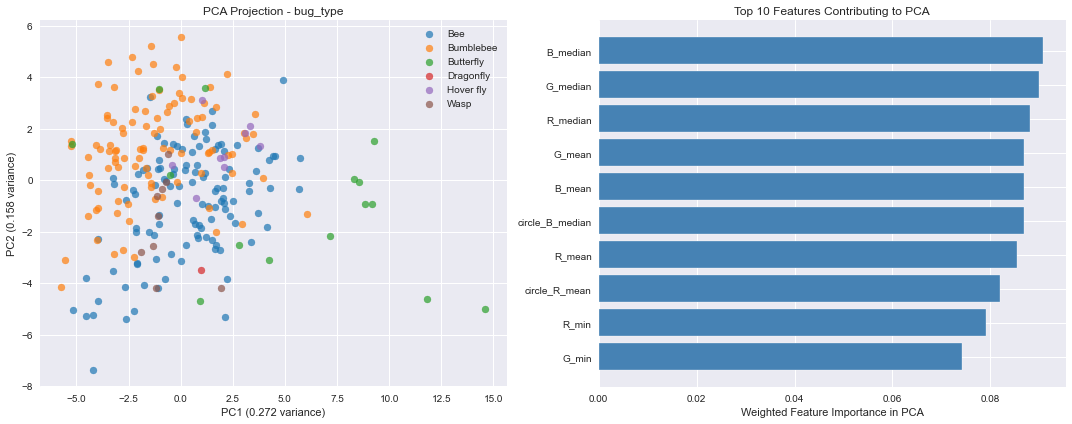

=== Running PCA ===
Number of features: 34
Targetted classes: reduced_bug_type
PCA Variance explained by first 2 components: [0.27201158 0.15828177]
Total variance explained: 0.430


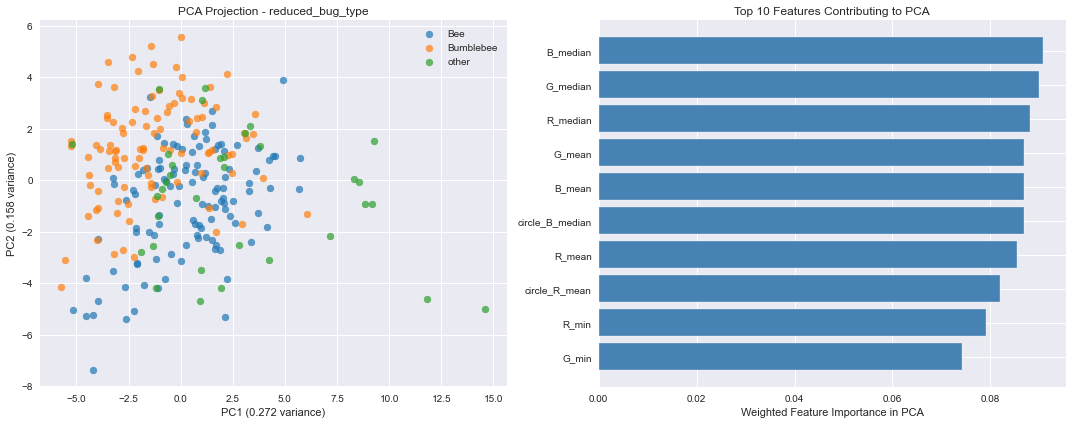

=== Running PCA ===
Number of features: 34
Targetted classes: species
PCA Variance explained by first 2 components: [0.27201158 0.15828177]
Total variance explained: 0.430


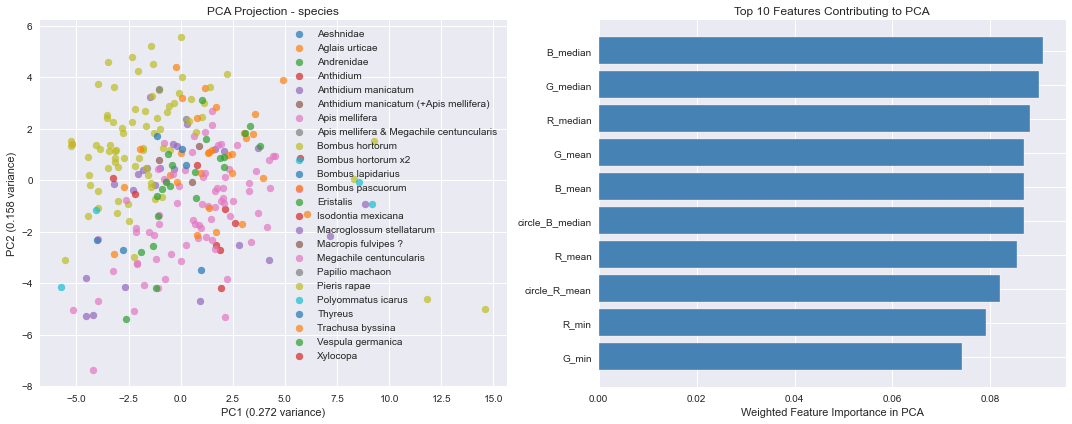

=== Running PCA ===
Number of features: 25
Targetted classes: bug_type
PCA Variance explained by first 2 components: [0.34913781 0.11905544]
Total variance explained: 0.468


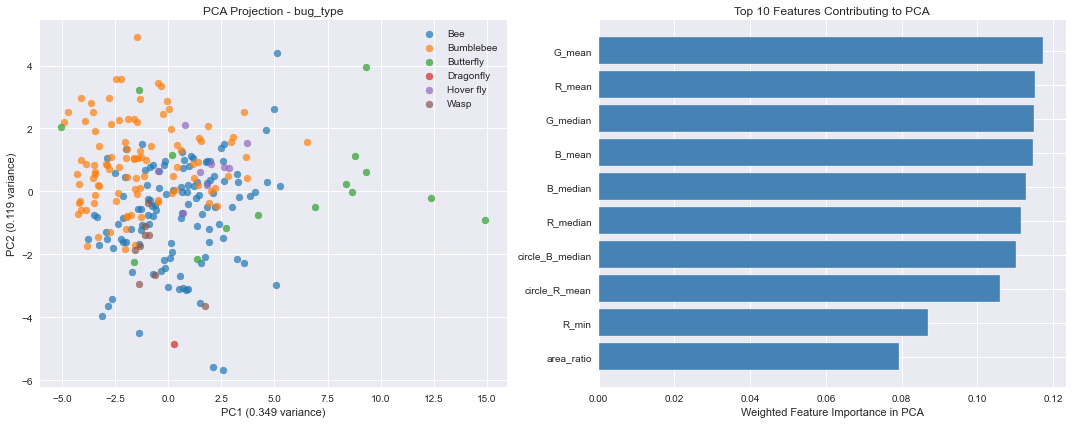

=== Running PCA ===
Number of features: 25
Targetted classes: reduced_bug_type
PCA Variance explained by first 2 components: [0.34913781 0.11905544]
Total variance explained: 0.468


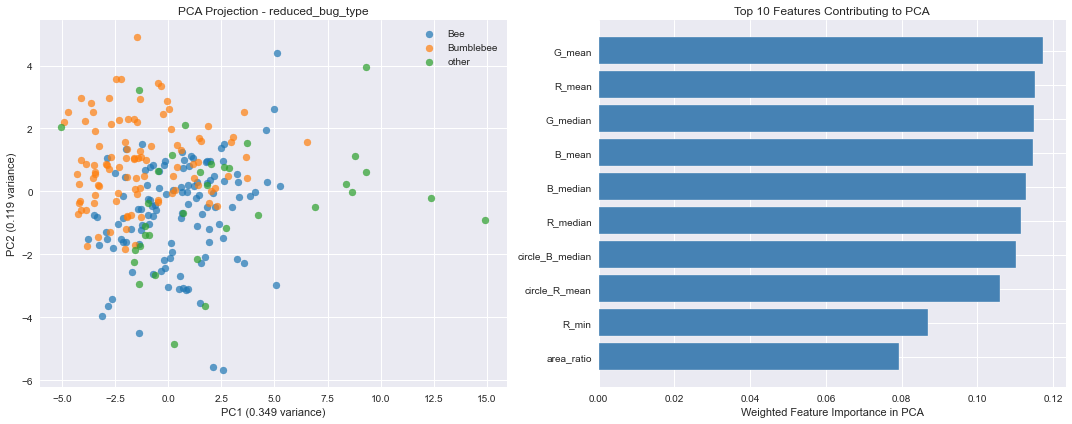

=== Running PCA ===
Number of features: 25
Targetted classes: species
PCA Variance explained by first 2 components: [0.34913781 0.11905544]
Total variance explained: 0.468


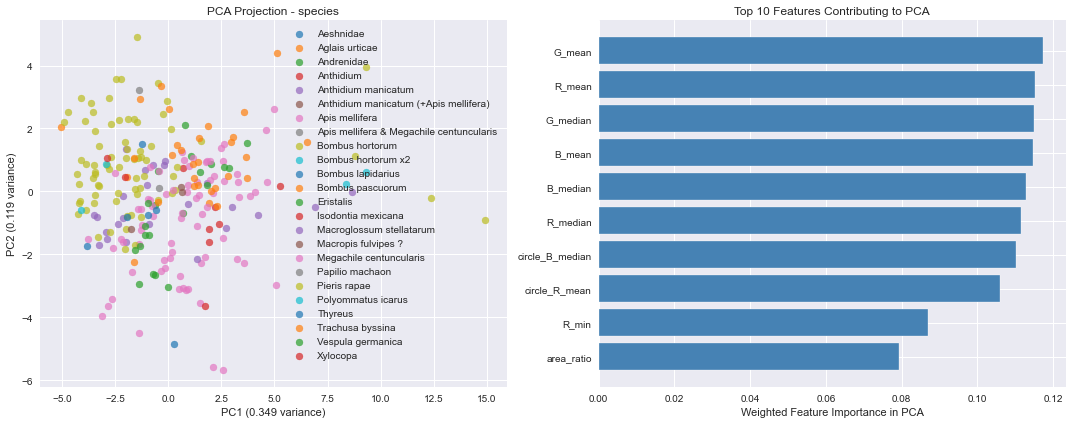

In [17]:
# Running PCA for each target classes and each features sets
y3 = df['species']

sets = [X, X_filtered]
targets = [y, y2, y3]

for i, (X_set, y_set) in enumerate([(s, t) for s in sets for t in targets]):
    run_pca(X_set, y_set)

<font color='yellow'><h5>f) Non-linear projections 

In [18]:
# Functions to run non linear projections
def non_linear_projections(X, y):
    print("\n=== NON-LINEAR PROJECTIONS ===")
    print(f"Running non linear projections for {y.name} with {X.shape[1]} features")

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # t-SNE projection
    print("Computing t-SNE projection...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)-1))
    X_tsne = tsne.fit_transform(X_scaled)

    # UMAP projection (if available, otherwise use another method)
    try:
        from umap import UMAP
        print("Computing UMAP projection...")
        umap_reducer = UMAP(n_components=2, random_state=42)
        X_umap = umap_reducer.fit_transform(X_scaled)
        has_umap = True
    except ImportError:
        print("UMAP not available, using Isomap instead...")
        from sklearn.manifold import Isomap
        isomap = Isomap(n_components=2)
        X_umap = isomap.fit_transform(X_scaled)
        has_umap = False

    # Plot non-linear projections
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    classes = sorted(y.unique())  
    colors = plt.cm.tab10.colors
    for i, cls in enumerate(classes):
        mask = (y == cls)
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=cls, color=colors[i % len(colors)], alpha=0.7)

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title(f't-SNE Projection - {y.name}')
    plt.legend()

    plt.subplot(1, 2, 2)

    for i, cls in enumerate(classes):
        mask = (y == cls)
        plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=cls, color=colors[i % len(colors)], alpha=0.7)
        
    plt.xlabel('UMAP 1' if has_umap else 'Isomap 1')
    plt.ylabel('UMAP 2' if has_umap else 'Isomap 2')
    plt.title(f'{"UMAP" if has_umap else "Isomap"} Projection - {y.name}')
    plt.legend()

    plt.tight_layout()
    plt.show()


=== NON-LINEAR PROJECTIONS ===
Running non linear projections for bug_type with 34 features
Computing t-SNE projection...
UMAP not available, using Isomap instead...


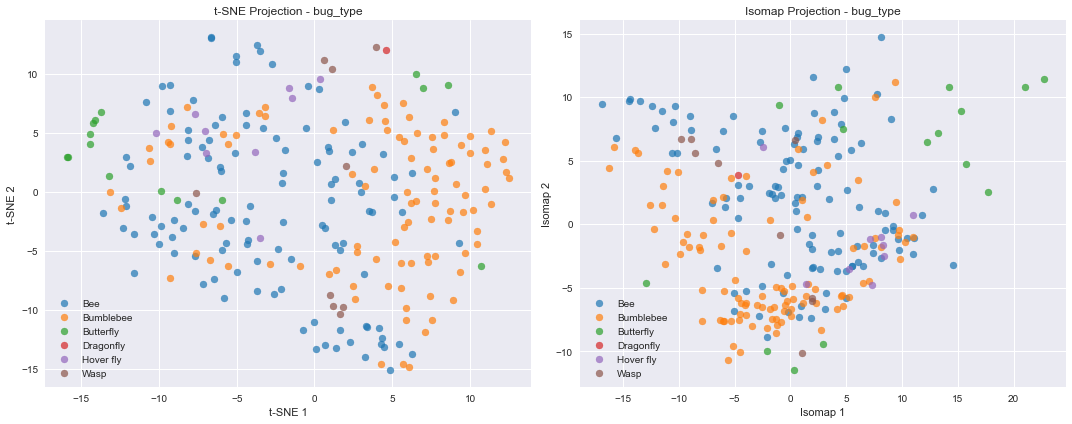


=== NON-LINEAR PROJECTIONS ===
Running non linear projections for reduced_bug_type with 34 features
Computing t-SNE projection...
UMAP not available, using Isomap instead...


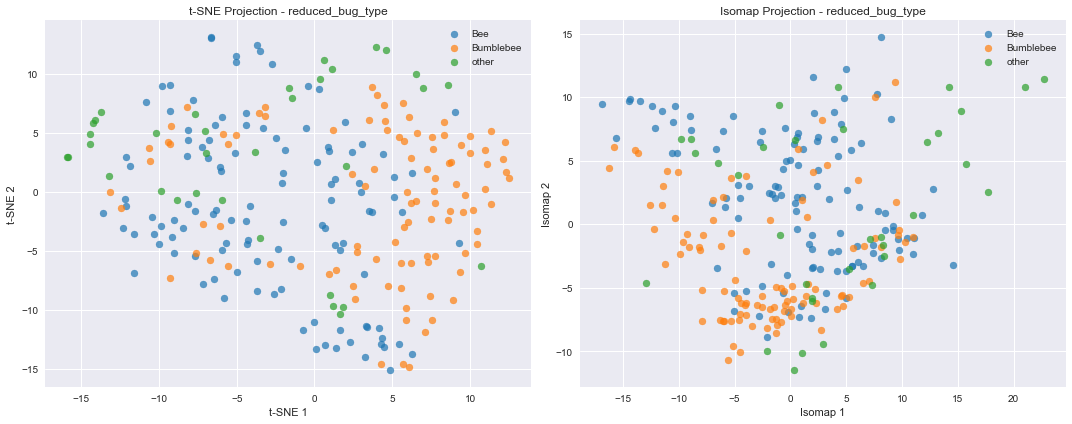


=== NON-LINEAR PROJECTIONS ===
Running non linear projections for species with 34 features
Computing t-SNE projection...
UMAP not available, using Isomap instead...


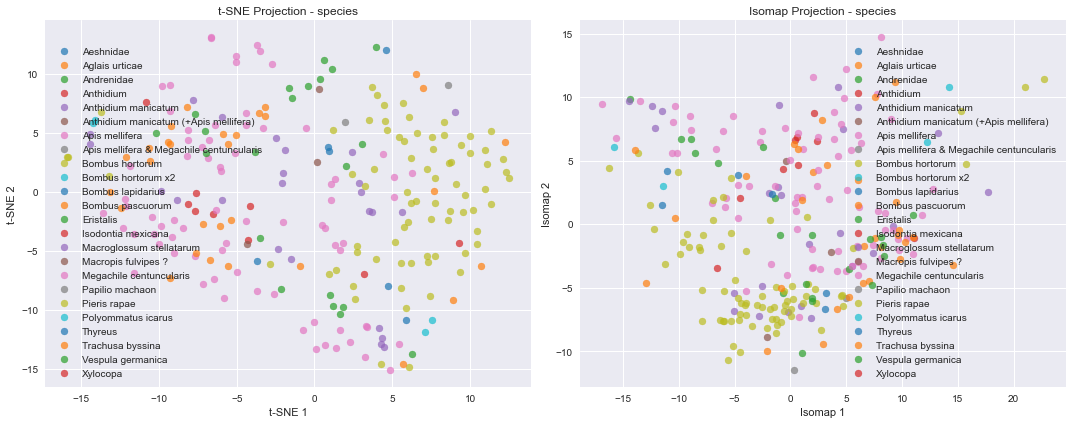


=== NON-LINEAR PROJECTIONS ===
Running non linear projections for bug_type with 25 features
Computing t-SNE projection...
UMAP not available, using Isomap instead...


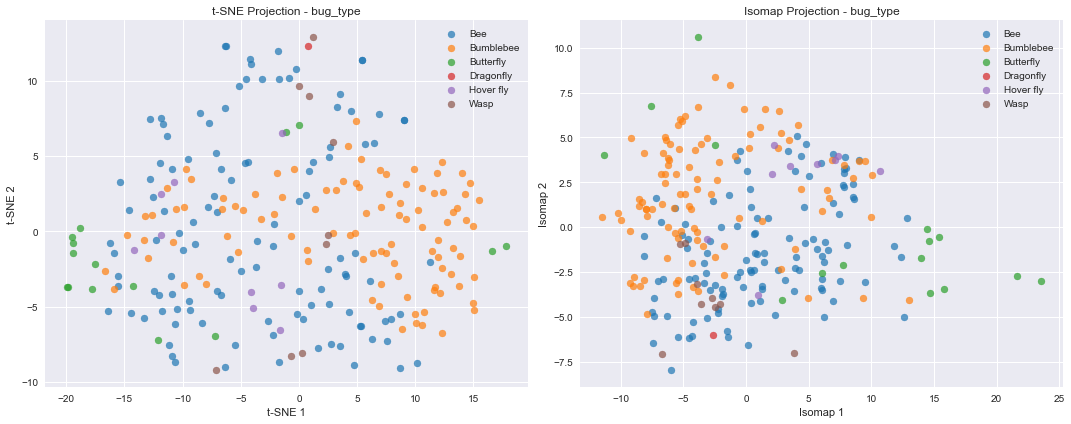


=== NON-LINEAR PROJECTIONS ===
Running non linear projections for reduced_bug_type with 25 features
Computing t-SNE projection...
UMAP not available, using Isomap instead...


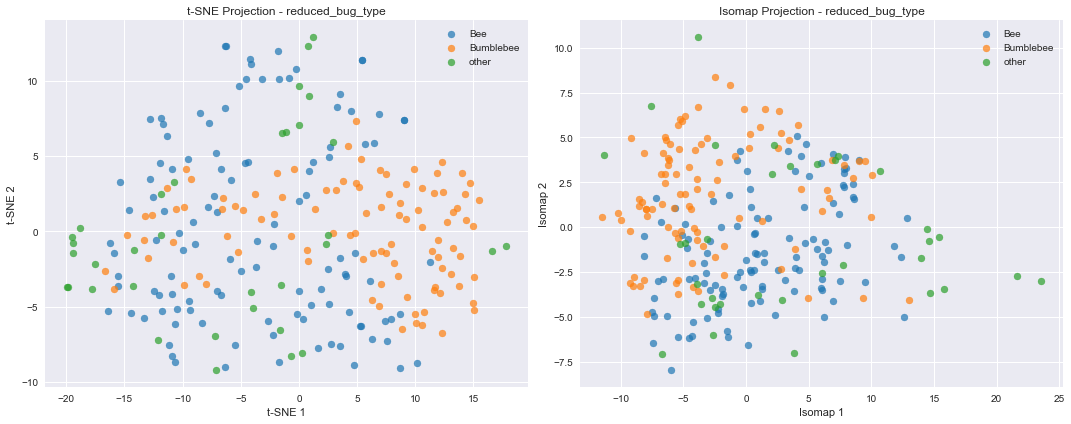


=== NON-LINEAR PROJECTIONS ===
Running non linear projections for species with 25 features
Computing t-SNE projection...
UMAP not available, using Isomap instead...


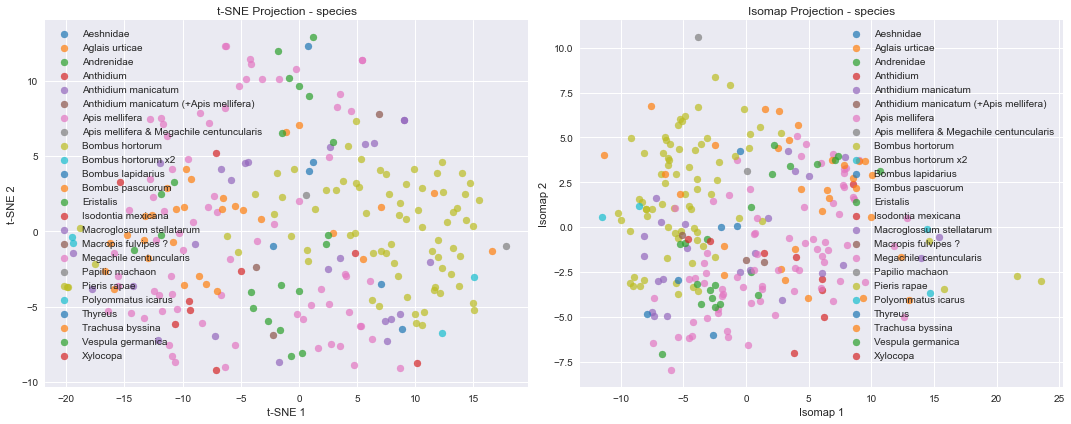

In [19]:
# Running non linear projections for each target classes and each features sets
for i, (X_set, y_set) in enumerate([(s, t) for s in sets for t in targets]):
    non_linear_projections(X_set, y_set)

<font color='yellow'><h5>g) Second feature filtering after projections and RF tests

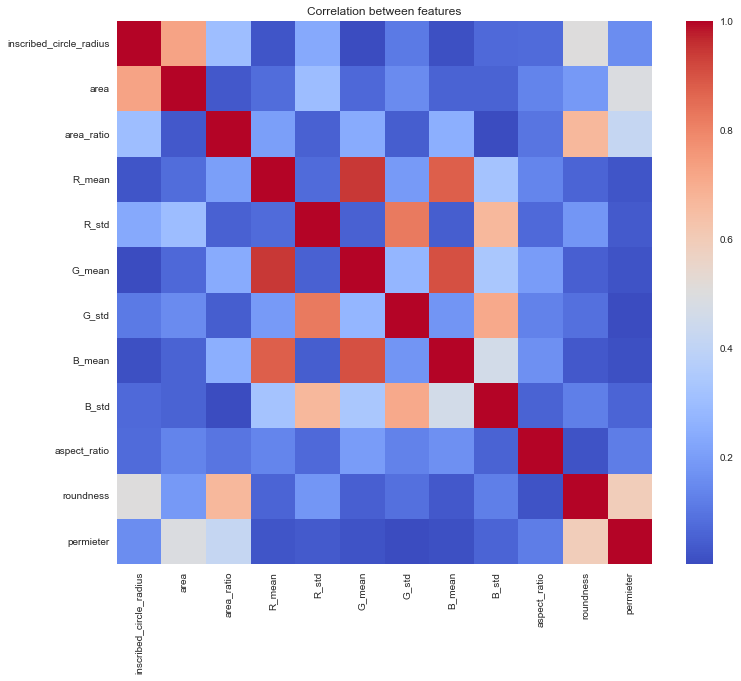

In [20]:
# Chosing manually which features to remove based on the previous results
X_filtered_2 = X.drop(columns=['R_max', 'G_max', 'B_max', 'R_min', 'G_min', 'B_min','R_median', 'G_median', 'B_median',
                               'glcm_homogeneity', 'glcm_energy', 'central_rgb_variation',
                               'circle_R_mean', 'circle_G_std', 'circle_B_median',
                               'extent', 'eccentricity','compactness', 'orientation',
                               'solidity','edge_density', 'wings_body_ratio'])


corr_matrix = X_filtered_2.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation between features")
plt.show()

<h3>6. Machine Learning Algorithms

In [42]:
# Data preparation for machine learning models
def ml_preparation(X, y):
    
    # Encoding labels so it fits every models
    le = LabelEncoder()
    y_encoded = y
    
    # Full dataframe with encoded labels
    df_full = X.copy()
    df_full['label'] = y_encoded
    
    # Detecting rare classes (1 sample)
    class_counts = df_full['label'].value_counts()
    rare_classes = class_counts[class_counts == 1].index.tolist()
    
    # Separating rare classes
    rare_instances = df_full[df_full['label'].isin(rare_classes)]
    df_remaining = df_full[~df_full['label'].isin(rare_classes)]

    # Splitting remaining non rare classes
    X_remain = df_remaining.drop(columns='label')
    y_remain = df_remaining['label']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_remain,
        y_remain,
        test_size=0.3,
        random_state=42,
        stratify=y_remain if y_remain.value_counts().min() > 1 else None  # stratify si possible
    )
    
    # Forced addition of rare classes to the training set to learn them even without test
    X_train = pd.concat([X_train, rare_instances.drop(columns='label')])
    y_train = pd.concat([y_train, rare_instances['label']])

    # Scaling
    scaler_ml = StandardScaler()
    X_train_scaled = scaler_ml.fit_transform(X_train)
    X_test_scaled = scaler_ml.transform(X_test)
    
    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler_ml, le
    

<font color='yellow'><h5>a) Supervised methods

In [22]:
# SVM method
def svm_manual_model(X_train_scaled, y_train, X_test_scaled, balance_type):
    print("\n--- RUNNING SVM Classifier ...")
    try:
        svm_clf = SVC(class_weight=balance_type, C=100, kernel='rbf', gamma=0.01, decision_function_shape='ovr')
        svm_clf.fit(X_train_scaled, y_train)
        svm_pred = svm_clf.predict(X_test_scaled)
        return svm_clf, svm_pred
    except Exception as e:
        print(f"[ERROR] SVM model failed: {e}")
        return None, None

In [23]:
# KNN method
def knn_manual_model(X_train_scaled, y_train, X_test_scaled):
    print("\n--- RUNNING KNN Classifier ...")
    try:
        knn_clf = KNeighborsClassifier(n_neighbors=5)
        knn_clf.fit(X_train_scaled, y_train)
        knn_pred = knn_clf.predict(X_test_scaled)
        return knn_clf, knn_pred
    except Exception as e:
        print(f"[ERROR] KNN model failed: {e}")
        return None, None

In [24]:
# Logistic regression method
def logistic_regression_manual_model(X_train_scaled, y_train, X_test_scaled, balance_type):
    try:
        print("\n--- RUNNING Logistic Regression ...")
        lr_clf = LogisticRegression(random_state=42, max_iter=500, class_weight=balance_type)
        lr_clf.fit(X_train_scaled, y_train)
        lr_pred = lr_clf.predict(X_test_scaled)
        return lr_clf, lr_pred
    except Exception as e:
        print(f"[ERROR] Logistic Regression model failed: {e}")
        return None, None

In [25]:
# MLP method
def mlp_manual_model(X_train_scaled, y_train, X_test_scaled):
    try:
        print("\n--- RUNNING MLP Classifier ...")
        mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
        mlp_clf.fit(X_train_scaled, y_train)
        mlp_pred = mlp_clf.predict(X_test_scaled)
        return mlp_clf, mlp_pred
    except Exception as e:
        print(f"[ERROR] MLP model failed: {e}")
        return None, None

<font color='yellow'><h5>b) Ensemble learning methods

In [26]:
# Random Forest method
def random_forest_manual_model(X_train, y_train, X_test, balance_type):
    print("\n--- RUNNING Random Forest Classifier ...")
    try:
        rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=balance_type)
        rf_clf.fit(X_train, y_train)
        rf_pred = rf_clf.predict(X_test)
        return rf_clf, rf_pred
    except Exception as e:
        print(f"[ERROR] Random Forest model failed: {e}")
        return None, None

In [27]:
# XGBoost method
def xgboost_manual_model(X_train, y_train, X_test):
    print("\n--- RUNNING XGBoost Classifier ...")
    try:
        xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
        xgb_clf.fit(X_train, y_train)
        xgb_pred = xgb_clf.predict(X_test)
        return xgb_clf, xgb_pred
    except Exception as e:
        print(f"[ERROR] XGBoost model failed: {e}")
        return None, None

<font color='yellow'><h5>c) Clustering Methods

In [28]:
# K-means clustering
def kmeans_clustering(X_scaled, y):
    try:
        print("\n--- RUNNING K-Means Clustering ...")
        n_clusters = len(y.unique())
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(X_scaled)
        kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
        print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")
        return kmeans_labels, kmeans_silhouette
    except Exception as e:
        print(f"[ERROR] K-Means clustering failed: {e}")
        return None, None

In [29]:
# DBscan clustering
def dbscan_clustering(X_scaled):
    try:
        print("\n--- RUNNING DBSCAN Clustering ...")
        dbscan = DBSCAN(eps=4.46, min_samples=20)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        print(f"DBSCAN - Estimated clusters: {n_clusters_dbscan}")
        print(f"DBSCAN - Noise points: {n_noise}")
        
        if n_clusters_dbscan > 1:
            dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
            print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")
        
        return dbscan_labels, n_clusters_dbscan, n_noise
    except Exception as e:
        print(f"[ERROR] DBSCAN clustering failed: {e}")
        return None, None, None

In [30]:
# Hierarchical clustering
def hierarchical_clustering(X_scaled, y):
    try:
        print("\n--- RUNNING Hierarchical Clustering ...")
        n_clusters = len(y.unique())
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        hierarchical_labels = hierarchical.fit_predict(X_scaled)
        hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
        print(f"Hierarchical Silhouette Score: {hierarchical_silhouette:.3f}")
        return hierarchical_labels, hierarchical_silhouette
    except Exception as e:
        print(f"[ERROR] Hierarchical clustering failed: {e}")
        return None, None

In [31]:
# Display clustering plots
def display_clustering_results(kmeans_labels, dbscan_labels, hierarchical_labels, kmeans_silhouette, n_clusters_dbscan, n_noise, hierarchical_silhouette, X_pca):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10')
    plt.title(f'K-Means Clustering\n(Silhouette: {kmeans_silhouette:.3f})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.subplot(1, 3, 2)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab10')
    plt.title(f'DBSCAN Clustering\n(Clusters: {n_clusters_dbscan}, Noise: {n_noise})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.subplot(1, 3, 3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='tab10')
    plt.title(f'Hierarchical Clustering\n(Silhouette: {hierarchical_silhouette:.3f})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.tight_layout()
    plt.show()
    
    return

<font color='yellow'><h5>d) Hyperparameter Optimization 

In [32]:
# Defining hyperparameter distributions for each model
param_dist_svc = {
    'C': uniform(0.1, 200),        
    'gamma': uniform(1e-4, 1e-1),   # de 0.0001 à 0.1
    'kernel': ['rbf'],
    'decision_function_shape': ['ovo', 'ovr'],
    'class_weight': ['balanced', None]
}

param_dist_knn = {
    'n_neighbors': randint(3, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

param_dist_logreg = {
    'C': loguniform(1e-3, 100),  # régularisation inverse
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000]
}

param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': loguniform(1e-5, 1e-2),   # régularisation L2
    'learning_rate_init': loguniform(1e-4, 1e-2),
    'max_iter': [300, 500]
}

param_dist_rf = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

param_dist_xgb = {
    'n_estimators': randint(50, 120),
    'max_depth': randint(3, 6),
    'learning_rate': loguniform(0.05, 0.2),
    'subsample': uniform(0.7, 0.2),
    'colsample_bytree': uniform(0.7, 0.2),
}

In [33]:
# Pipeline function to perform both randomized search and grid search for each models
def tuned_search_pipeline(model, X, y,
                          random_param_dist,
                          fixed_params=None,
                          scoring='balanced_accuracy',
                          cv=5,
                          n_iter=50,
                          refinement_factors=[0.5, 1.0, 2.0],
                          random_state=42,
                          verbose=1):
    """
    Enchaîne RandomizedSearchCV puis GridSearchCV pour un modèle donné.

    Parameters:
    - model: modèle sklearn
    - X, y: données d'entraînement
    - random_param_dist: dict compatible avec RandomizedSearchCV
    - fixed_params: dict de paramètres à fixer (ex: kernel='rbf')
    - scoring: métrique d'évaluation
    - cv: nombre de folds
    - n_iter: itérations du RandomizedSearch
    - refinement_factors: multiplicateurs pour créer la grille locale
    - random_state: pour la reproductibilité
    - verbose: niveau de verbosité

    Returns:
    - best_model: modèle entraîné avec les meilleurs paramètres finaux
    - best_params: dictionnaire des meilleurs hyperparamètres
    """

    # Step 1: Randomized Search
    if fixed_params:
        model.set_params(**fixed_params)

    random_search = RandomizedSearchCV(
        model,
        param_distributions=random_param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        random_state=random_state,
        verbose=verbose
    )
    random_search.fit(X, y)
    best_params = random_search.best_params_
    
    print(f"Best parameters from RandomizedSearchCV: {best_params}")

    # Generating GridSearch based on best randomized parameters
    refined_grid = {}
    for param, value in best_params.items():
        if isinstance(value, bool):
            # Boolean: keep as-is
            refined_grid[param] = [value]
        elif isinstance(value, int):
            values = list(set([int(value * f) for f in refinement_factors if int(value * f) > 0]))
            if not values:
                values = [value]  # fallback if grid ends up empty
            refined_grid[param] = values
        elif isinstance(value, float):
            values = sorted(list(set([round(value * f, 6) for f in refinement_factors if value * f > 0])))
            if not values:
                values = [value]
            refined_grid[param] = values
        else:
            # str, categorical, etc.
            refined_grid[param] = [value]

    # Step 2: Grid Search 
    grid_search = GridSearchCV(
        model,
        param_grid=refined_grid,
        scoring=scoring,
        cv=cv,
        verbose=verbose
    )
    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.best_params_

In [44]:
# Function to run tuned models
def run_tuned_models(X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled, scoring_target):
    models = {
        'SVM': (SVC(), param_dist_svc),
        'KNN': (KNeighborsClassifier(), param_dist_knn),
        'Logistic Regression': (LogisticRegression(), param_dist_logreg),
        'MLP': (MLPClassifier(), param_dist_mlp),
        'Random Forest': (RandomForestClassifier(), param_dist_rf),
    }

    results = {}

    for model_name, (model, param_dist) in models.items():
        print(f"\n--- Tuning {model_name} ---")
        
        # If the model requires scaling, use the scaled data
        if model_name in ['SVM', 'KNN', 'Logistic Regression', 'MLP']:
            X_used = X_train_scaled
            X_test_used = X_test_scaled
        else:
            X_used = X_train
            X_test_used = X_test
            
        # Perform tuned search
        best_model, best_params = tuned_search_pipeline(
            model,
            X_used,
            y_train,
            random_param_dist=param_dist,
            scoring=scoring_target,
            cv=5,
            n_iter=50,
            random_state=42,
            verbose=1
        )
        
        # Predict and store results
        y_pred = best_model.predict(X_test_used)
        
        results[model_name] = {
            'model': best_model,
            'params': best_params,
            'pred': y_pred
        }

    return results

<font color='yellow'><h5>e) Voting / Stacking classifier

In [35]:
# Voting Classifier
def run_voting_clf(results, X_train_scaled, y_train, X_test_scaled):
    print("\n--- RUNNING Voting Classifier ...")
    try:
        tuned_model_names = list(results.keys())
        voting_estimators = [(name, results[name]['model']) for name in tuned_model_names]
        voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')
        voting_clf.fit(X_train_scaled, y_train)
        voting_pred = voting_clf.predict(X_test_scaled)
        return voting_clf, voting_pred
    except Exception as e:
        print(f"[ERROR] Voting Classifier failed: {e}")
        return None, None

In [36]:
# Best stacking classifier function
def find_best_stacking_combination(results, X_train, y_train, scoring='balanced_accuracy', class_weight='balanced'):
    best_score = 0
    best_combo = None
    best_model = None

    model_entries = [(name, info['model']) for name, info in results.items()]
    
    for r in range(2, len(model_entries)+1):
        for combo in combinations(model_entries, r):
            try:
                stacking = StackingClassifier(
                    estimators=list(combo),
                    final_estimator=LogisticRegression(class_weight='balanced'),
                    passthrough=False,
                    cv=5
                )
                scores = cross_val_score(stacking, X_train, y_train, cv=5, scoring=scoring)
                avg_score = np.mean(scores)
                if avg_score > best_score:
                    best_score = avg_score
                    best_combo = combo
                    best_model = stacking
            except Exception as e:
                print(f"Skipping combo {[name for name, _ in combo]} due to error: {e}")
                continue

    return best_combo, best_model, best_score

<font color='yellow'><h5> Performing each methods on each targets and features sets

In [37]:
# PLotting function of the models results
def plot_model_evaluations(y_true, model_preds, model_names):
    
    n_models = len(model_preds)
    
    # 1. Confusion Matrices
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i in range(n_models):
        cm = confusion_matrix(y_true, model_preds[i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f"{model_names[i]}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Real")
    
    plt.tight_layout()
    plt.show()
    
    # 2. Computing and plotting metrics 
    scores = {
        "Accuracy": [],
        "Balanced Accuracy": [],
        "Recall (macro)": [],
        "F1-score (macro)": []
    }

    for pred in model_preds:
        scores["Accuracy"].append(accuracy_score(y_true, pred))
        scores["Balanced Accuracy"].append(balanced_accuracy_score(y_true, pred))
        scores["Recall (macro)"].append(recall_score(y_true, pred, average='macro'))
        scores["F1-score (macro)"].append(f1_score(y_true, pred, average='macro'))

    # Plot des bar charts
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    width = 0.15
    x = range(n_models)

    for i, (metric, values) in enumerate(scores.items()):
        ax.bar([p + i * width for p in x], values, width=width, label=metric)

    ax.set_xticks([p + 1.5 * width for p in x])
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylabel("Score")
    ax.set_title("Comparaison des performances des modèles")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [38]:
# Function to get the pca features for a given X
def get_pca(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca

In [46]:
# Main function to run all models on all features / classes pairs
def run_ml(X,y):
    print(f"\n=== RUNNING MACHINE LEARNING MODELS FOR {y.name} WITH {X.shape[1]} FEATURES ===")
    # Prepare data for machine learning
    if y.unique().size > 3:
        target_metric = 'balanced_accuracy'
        balance_type = 'balanced'  # Use balanced class weights for multi-class problems
    else:
        target_metric = 'accuracy' # We only want to focus on accuracy for reduced bug types
        balance_type = None
    
    X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler, le = ml_preparation(X, y)
    
    # Run clustering methods
    print("\n=== RUNNING CLUSTERING METHODS ===")
    kmeans_labels, kmeans_silhouette = kmeans_clustering(X_train_scaled, y)
    dbscan_labels, n_clusters_dbscan, n_noise = dbscan_clustering(X_train_scaled)
    hierarchical_labels, hierarchical_silhouette = hierarchical_clustering(X_train_scaled, y)
    X_pca = get_pca(X_train_scaled)
    display_clustering_results(kmeans_labels, dbscan_labels, hierarchical_labels, kmeans_silhouette, n_clusters_dbscan, n_noise, hierarchical_silhouette, X_pca)
    
    # Run bases models : 
    svm_clf, svm_pred = svm_manual_model(X_train_scaled, y_train, X_test_scaled, balance_type)
    knn_clf, knn_pred = knn_manual_model(X_train_scaled, y_train, X_test_scaled)
    lr_clf, lr_pred = logistic_regression_manual_model(X_train_scaled, y_train, X_test_scaled, balance_type)
    mlp_clf, mlp_pred = mlp_manual_model(X_train_scaled, y_train, X_test_scaled)
    rf_clf, rf_pred = random_forest_manual_model(X_train, y_train, X_test, balance_type)
    
    model_preds = [svm_pred, knn_pred, lr_pred, mlp_pred, rf_pred]
    model_names = ['SVM', 'KNN', 'LogReg', 'MLP', 'RandomForest']
    
    plot_model_evaluations(y_test, model_preds, model_names)
    
    # Run tuned models
    print("\n=== RUNNING TUNED MODELS ===")
    results = run_tuned_models(X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled, target_metric)
    tuned_model_names = list(results.keys())
    tuned_model_preds = [results[name]['pred'] for name in tuned_model_names]
    plot_model_evaluations(y_test, tuned_model_preds, tuned_model_names)
    
    # Voting Classifier
    # voting_clf, voting_pred = run_voting_clf(results, X_train_scaled, y_train, X_test_scaled)
    
    # Stacking classifier
    """print("\n=== RUNNING STACKING COMBINATION SEARCH ===")
    best_combo, best_stacking_model, best_stack_score = find_best_stacking_combination(
        results, X_train_scaled, y_train, scoring=target_metric, class_weight=balance_type
    )

    if best_stacking_model:
        best_stacking_model.fit(X_train_scaled, y_train)
        stacking_pred = best_stacking_model.predict(X_test_scaled)
        combo_names = '+'.join([name for name, _ in best_combo])
        print(f"Best stacking combo: {combo_names} with score: {best_stack_score:.4f}")
    
    plot_model_evaluations(y_test, [stacking_pred], [f'Stacking ({combo_names})'])"""

    return {
        'manual_models': {
            'SVM': svm_clf,
            'KNN': knn_clf,
            'LogReg': lr_clf,
            'MLP': mlp_clf,
            'RandomForest': rf_clf
        },
        'tuned_models': {name: results[name]['model'] for name in tuned_model_names},

        'scaler': scaler,
        'label_encoder': le
    }


=== RUNNING MACHINE LEARNING MODELS FOR bug_type WITH 34 FEATURES ===

=== RUNNING CLUSTERING METHODS ===

--- RUNNING K-Means Clustering ...
K-Means Silhouette Score: 0.125

--- RUNNING DBSCAN Clustering ...
DBSCAN - Estimated clusters: 1
DBSCAN - Noise points: 70

--- RUNNING Hierarchical Clustering ...
Hierarchical Silhouette Score: 0.123


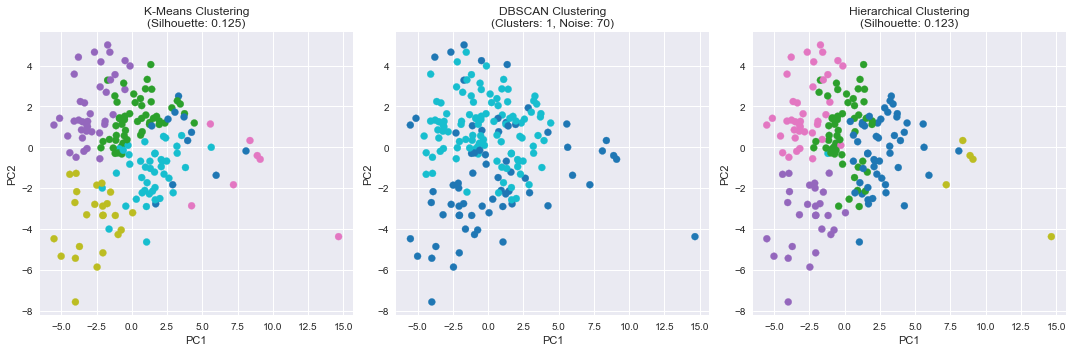


--- RUNNING SVM Classifier ...

--- RUNNING KNN Classifier ...

--- RUNNING Logistic Regression ...

--- RUNNING MLP Classifier ...

--- RUNNING Random Forest Classifier ...


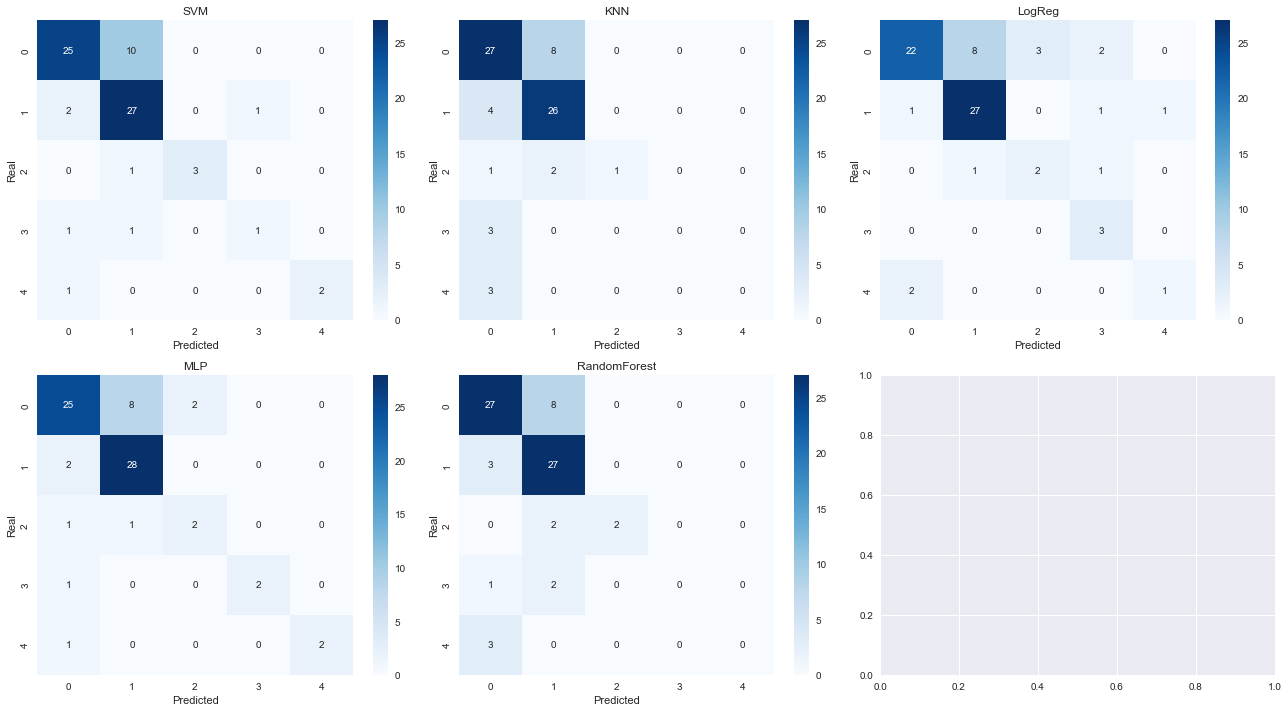

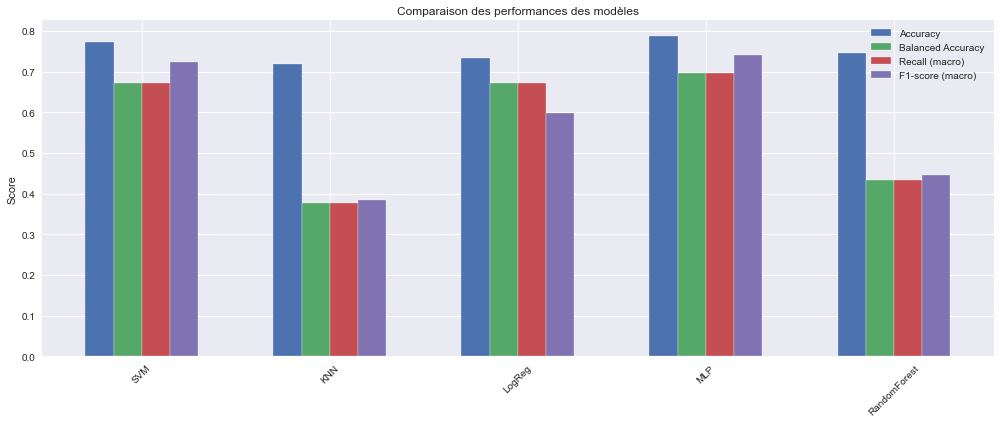


=== RUNNING TUNED MODELS ===

--- Tuning SVM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(104.64656587639881), 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': np.float64(0.002641912674409519), 'kernel': 'rbf'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning KNN ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(4.5705630998014515), 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning MLP ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters fr

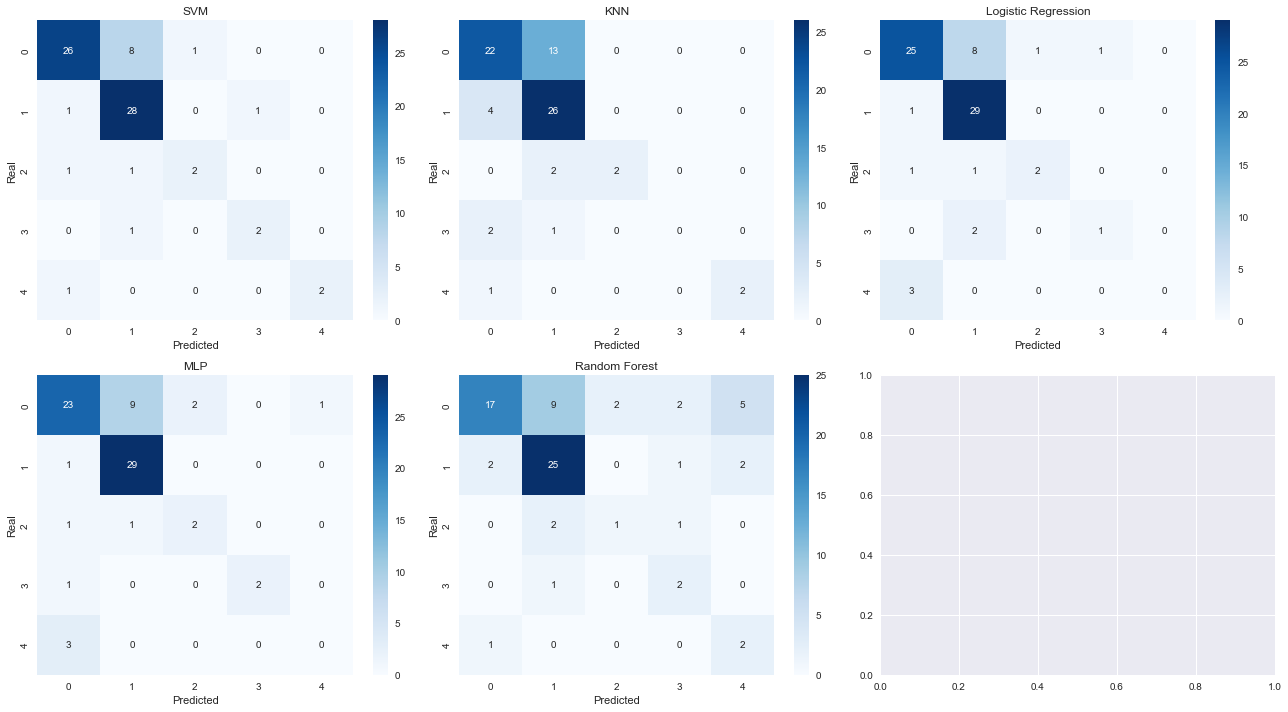

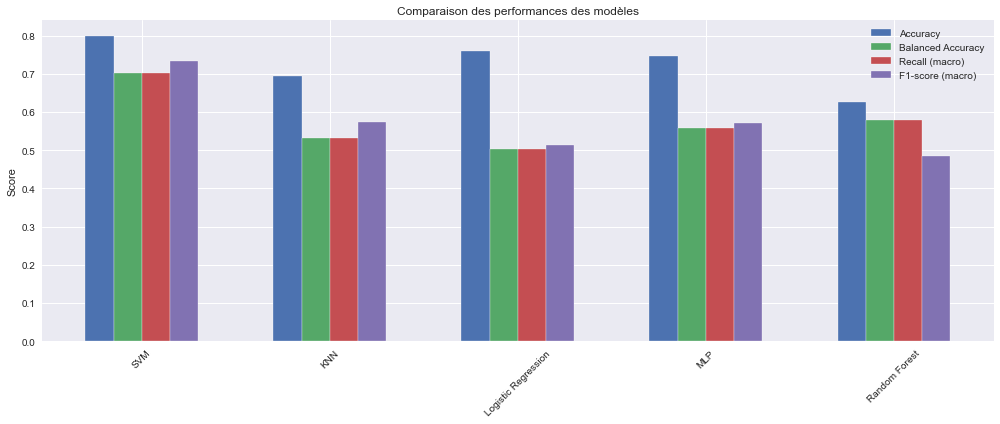


=== Finished running ML for Feature Set 1 - Targeted Class : bug_type - 249 feats ===

=== RUNNING MACHINE LEARNING MODELS FOR reduced_bug_type WITH 34 FEATURES ===

=== RUNNING CLUSTERING METHODS ===

--- RUNNING K-Means Clustering ...
K-Means Silhouette Score: 0.157

--- RUNNING DBSCAN Clustering ...
DBSCAN - Estimated clusters: 1
DBSCAN - Noise points: 77

--- RUNNING Hierarchical Clustering ...
Hierarchical Silhouette Score: 0.120


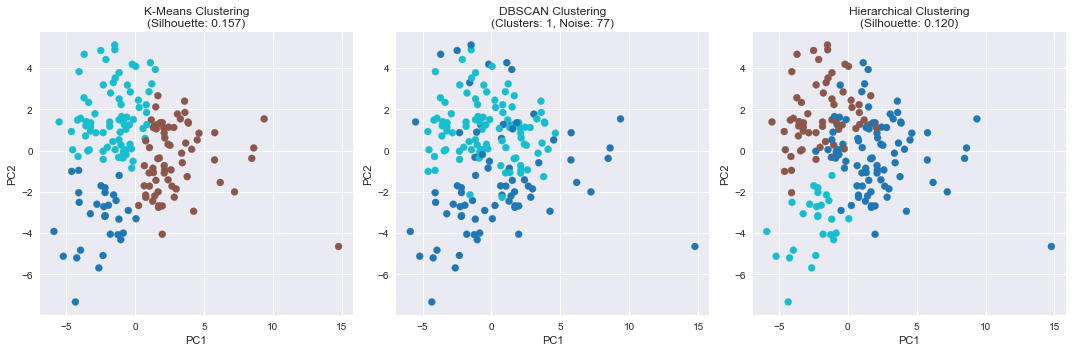


--- RUNNING SVM Classifier ...

--- RUNNING KNN Classifier ...

--- RUNNING Logistic Regression ...

--- RUNNING MLP Classifier ...

--- RUNNING Random Forest Classifier ...


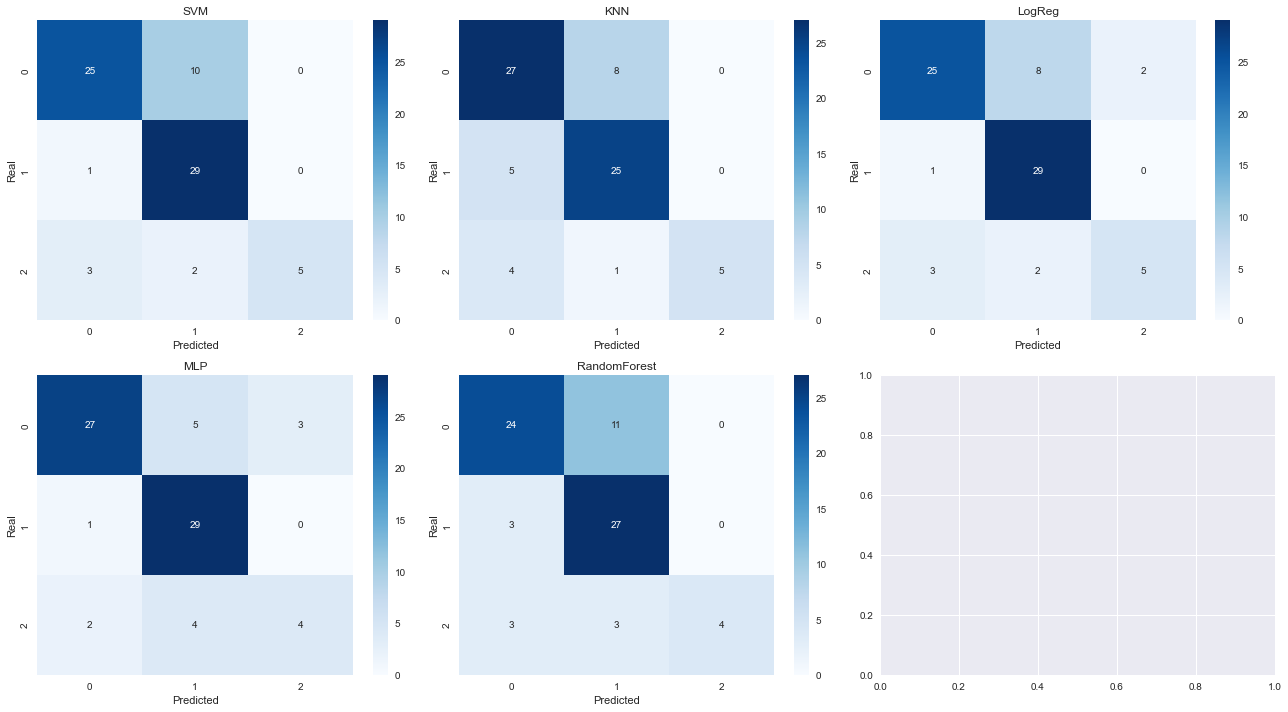

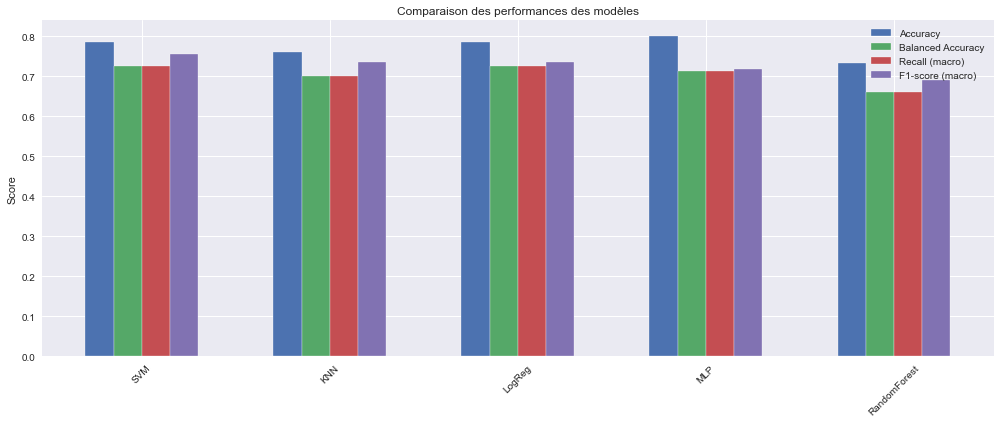


=== RUNNING TUNED MODELS ===

--- Tuning SVM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(163.70295318449863), 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': np.float64(0.0007952130531190705), 'kernel': 'rbf'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning KNN ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(13.921548533046511), 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning MLP ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters 

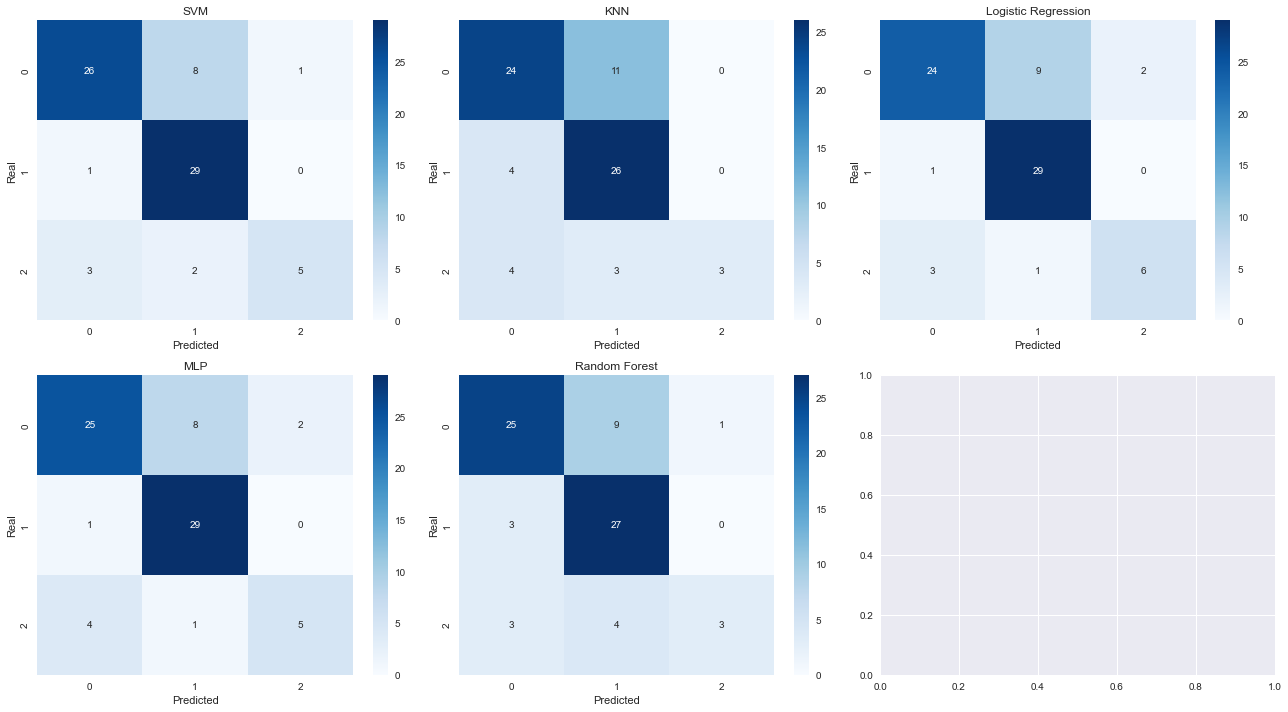

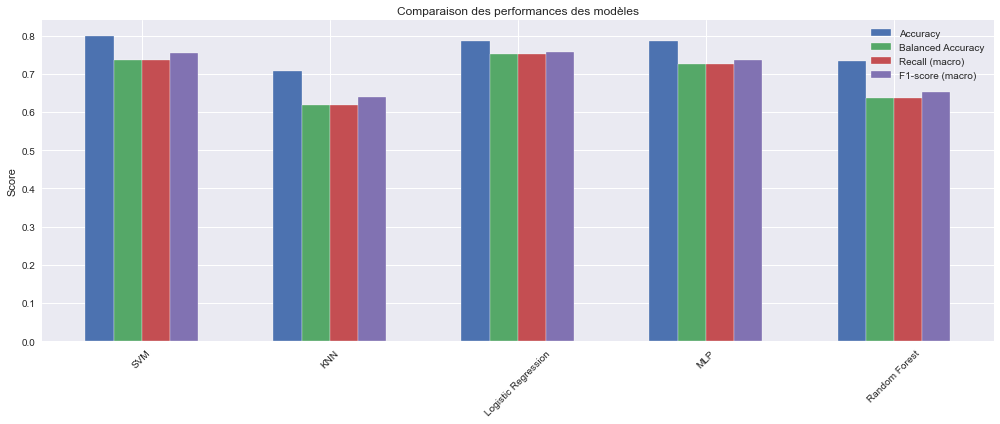


=== Finished running ML for Feature Set 2 - Targeted Class : reduced_bug_type - 249 feats ===

=== RUNNING MACHINE LEARNING MODELS FOR species WITH 34 FEATURES ===

=== RUNNING CLUSTERING METHODS ===

--- RUNNING K-Means Clustering ...
K-Means Silhouette Score: 0.083

--- RUNNING DBSCAN Clustering ...
DBSCAN - Estimated clusters: 1
DBSCAN - Noise points: 67

--- RUNNING Hierarchical Clustering ...
Hierarchical Silhouette Score: 0.104


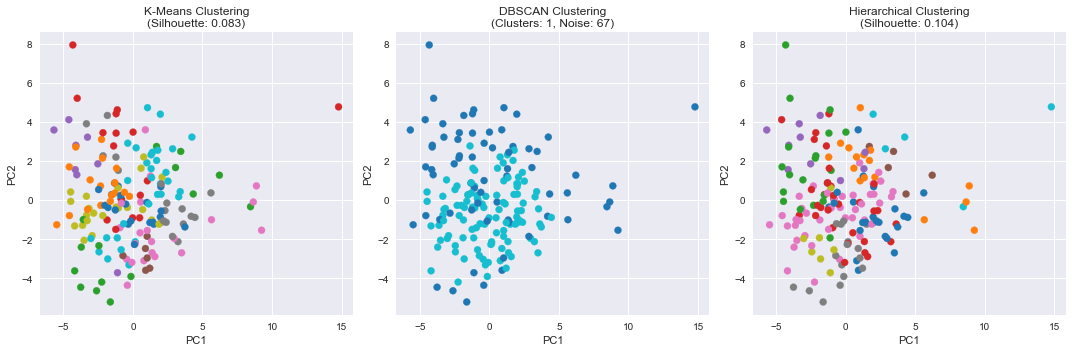


--- RUNNING SVM Classifier ...

--- RUNNING KNN Classifier ...

--- RUNNING Logistic Regression ...

--- RUNNING MLP Classifier ...

--- RUNNING Random Forest Classifier ...


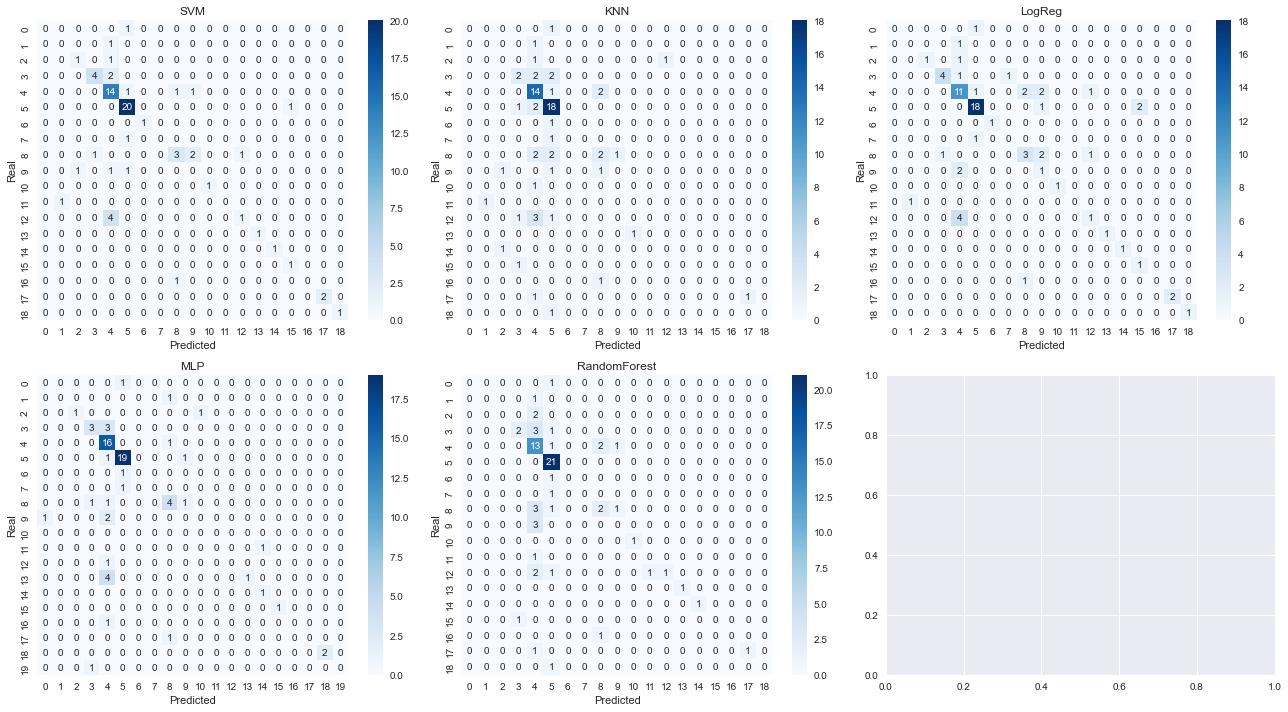

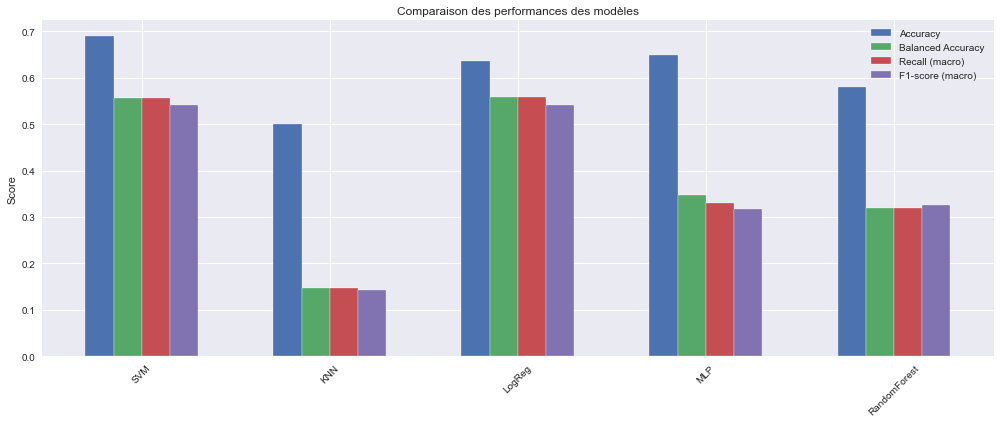


=== RUNNING TUNED MODELS ===

--- Tuning SVM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(145.90143360819746), 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': np.float64(0.007504465173409036), 'kernel': 'rbf'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning KNN ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(4.446628955475449), 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning MLP ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from Ra

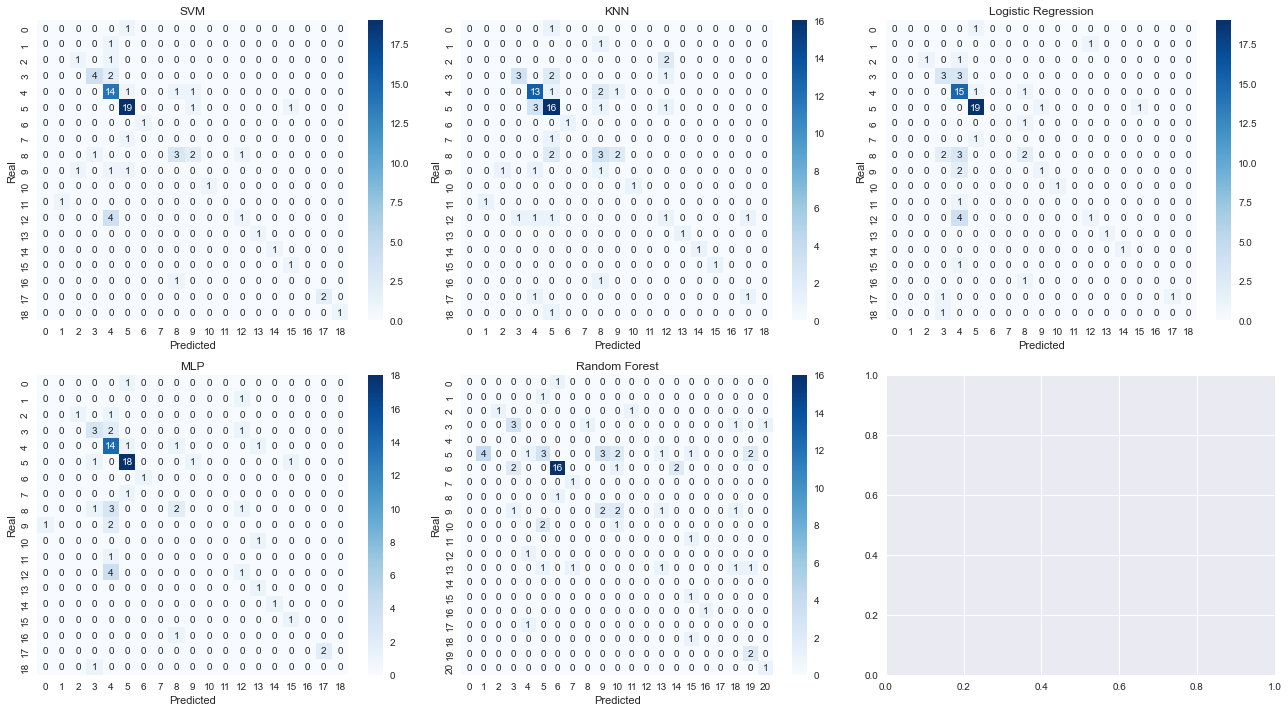

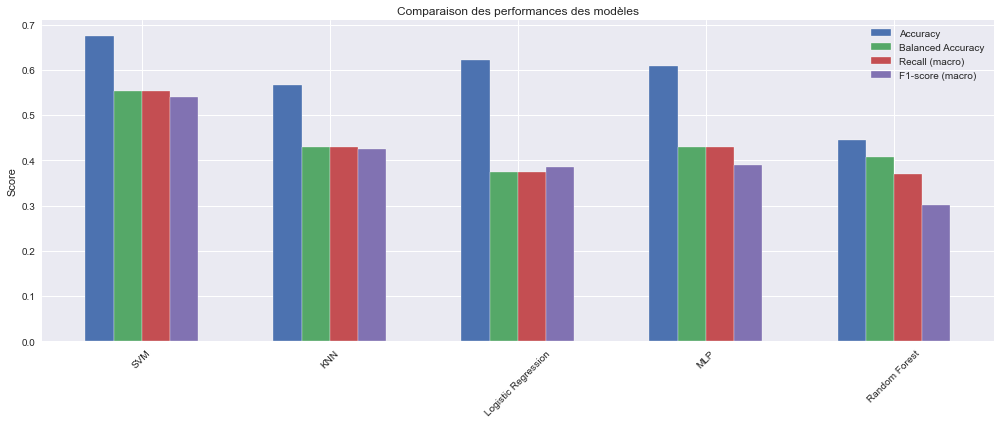


=== Finished running ML for Feature Set 3 - Targeted Class : species - 249 feats ===

=== RUNNING MACHINE LEARNING MODELS FOR bug_type WITH 25 FEATURES ===

=== RUNNING CLUSTERING METHODS ===

--- RUNNING K-Means Clustering ...
K-Means Silhouette Score: 0.119

--- RUNNING DBSCAN Clustering ...
DBSCAN - Estimated clusters: 1
DBSCAN - Noise points: 20

--- RUNNING Hierarchical Clustering ...
Hierarchical Silhouette Score: 0.105


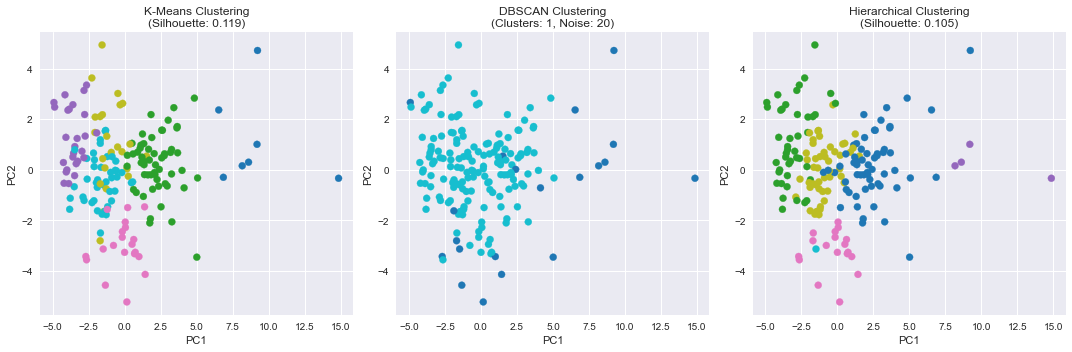


--- RUNNING SVM Classifier ...

--- RUNNING KNN Classifier ...

--- RUNNING Logistic Regression ...

--- RUNNING MLP Classifier ...

--- RUNNING Random Forest Classifier ...


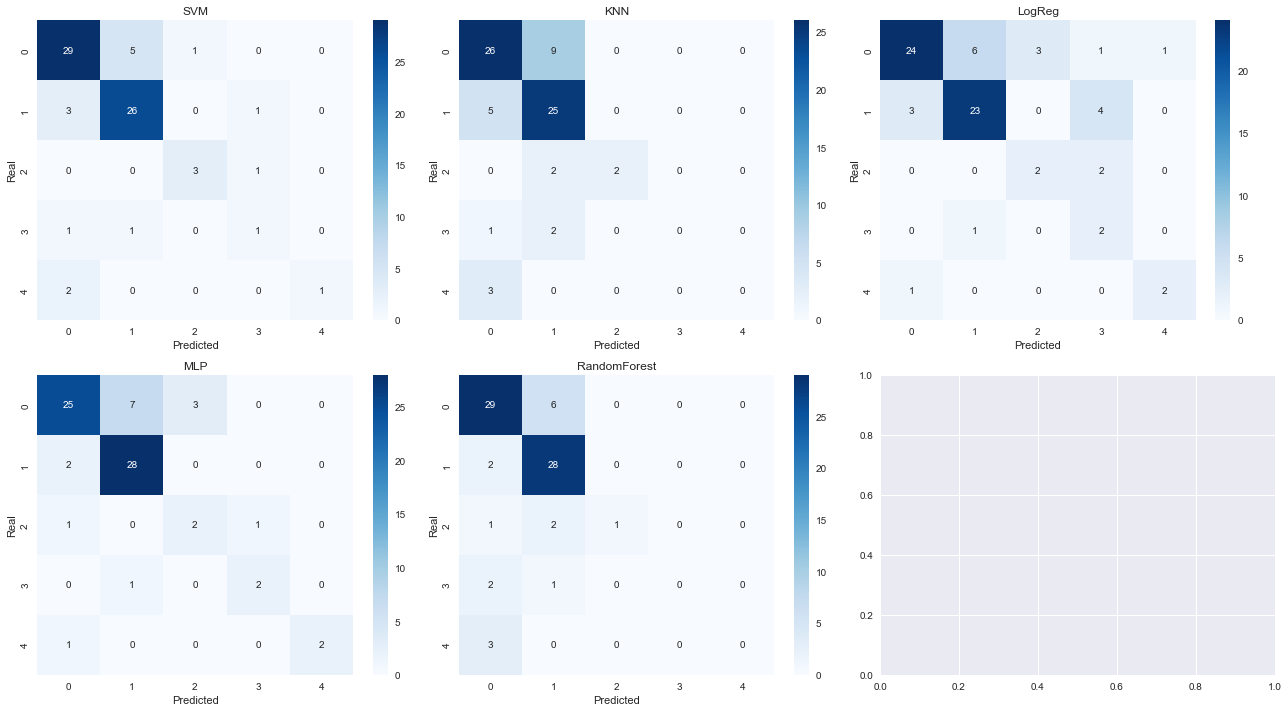

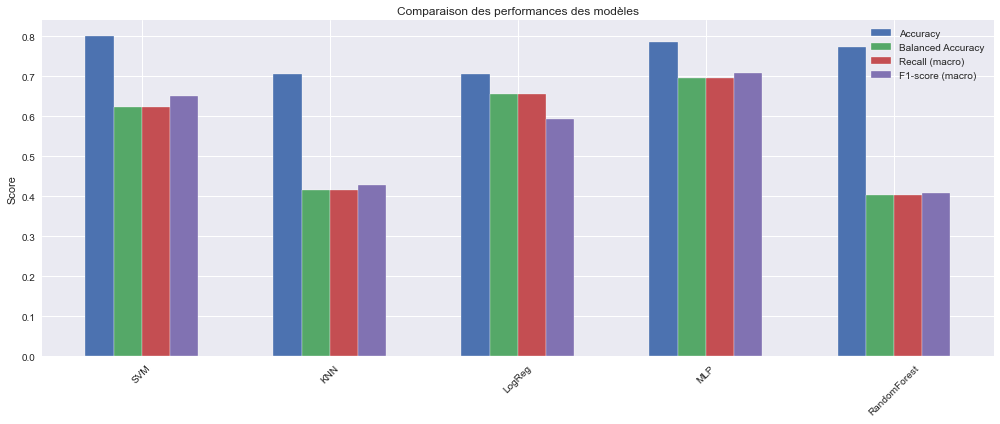


=== RUNNING TUNED MODELS ===

--- Tuning SVM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(100.6358046457723), 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': np.float64(0.027964646423661144), 'kernel': 'rbf'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning KNN ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(2.6373339933815254), 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning MLP ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from Randomize

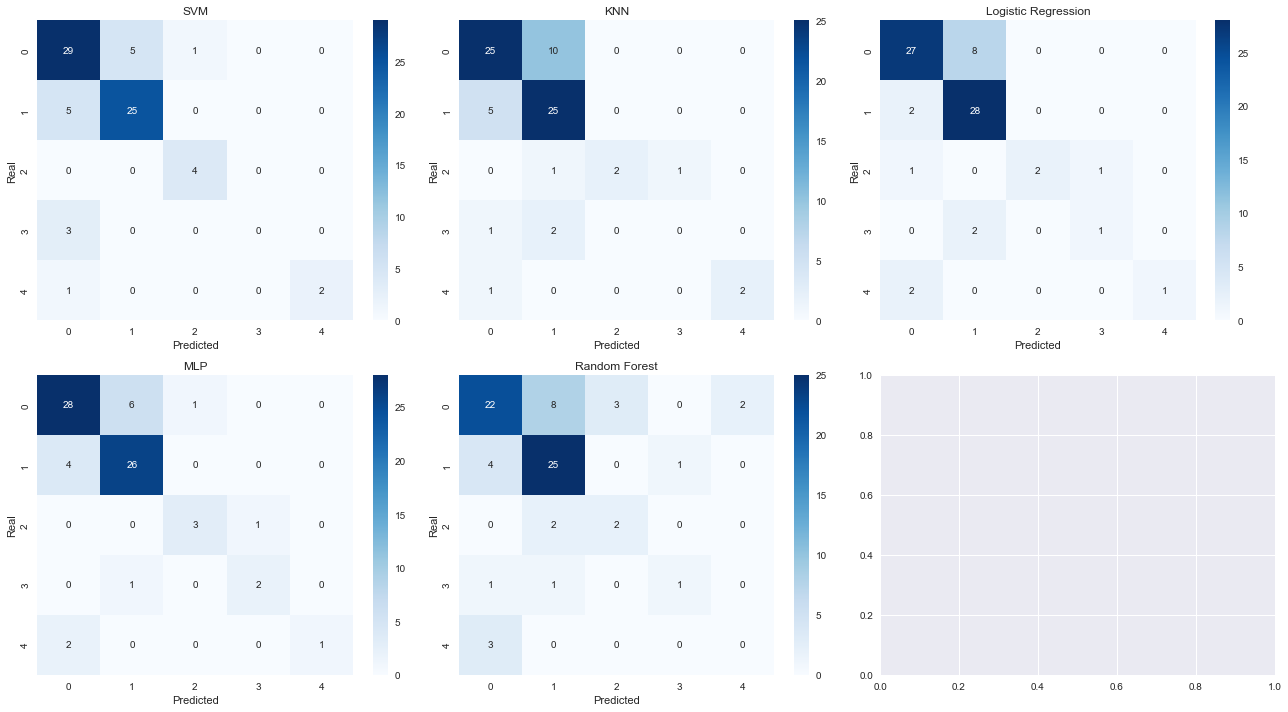

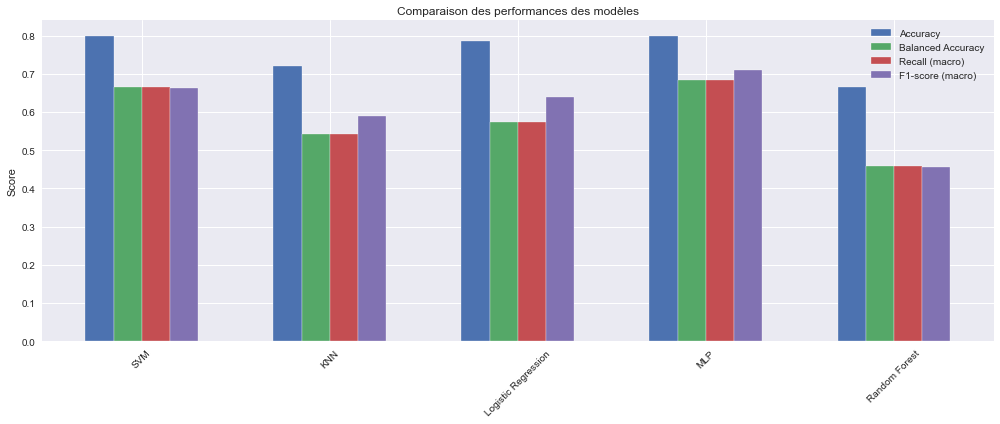


=== Finished running ML for Feature Set 4 - Targeted Class : bug_type - 249 feats ===

=== RUNNING MACHINE LEARNING MODELS FOR reduced_bug_type WITH 25 FEATURES ===

=== RUNNING CLUSTERING METHODS ===

--- RUNNING K-Means Clustering ...
K-Means Silhouette Score: 0.134

--- RUNNING DBSCAN Clustering ...
DBSCAN - Estimated clusters: 1
DBSCAN - Noise points: 18

--- RUNNING Hierarchical Clustering ...
Hierarchical Silhouette Score: 0.145


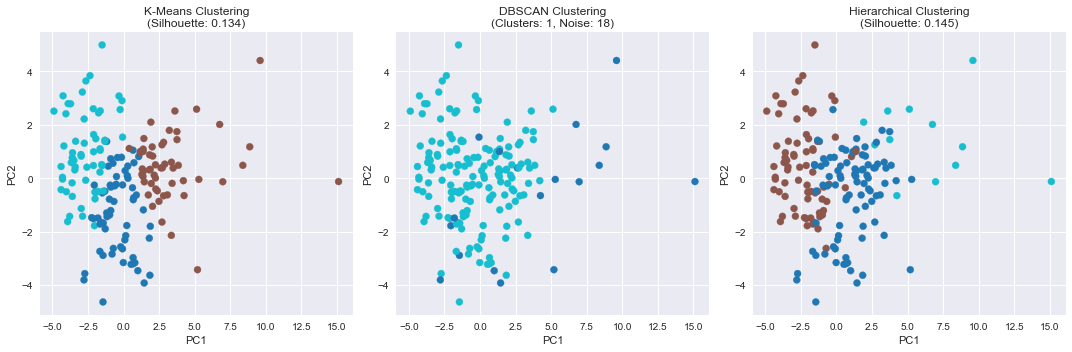


--- RUNNING SVM Classifier ...

--- RUNNING KNN Classifier ...

--- RUNNING Logistic Regression ...

--- RUNNING MLP Classifier ...

--- RUNNING Random Forest Classifier ...


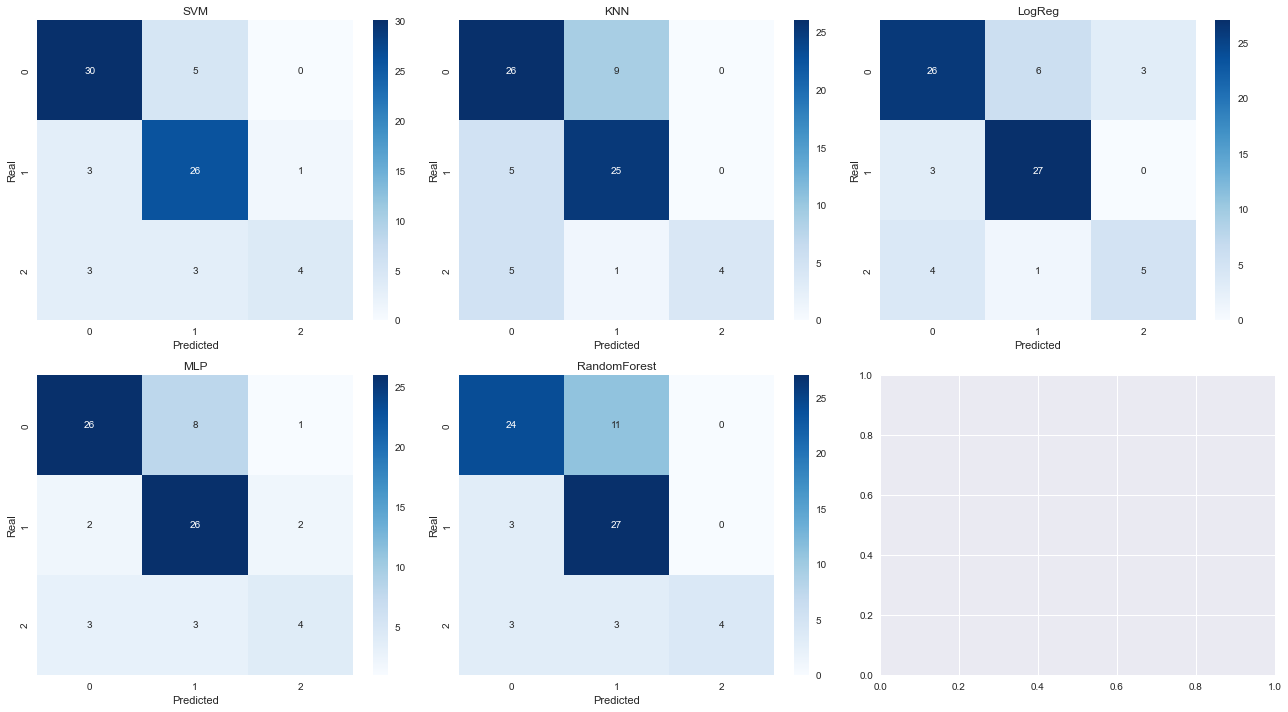

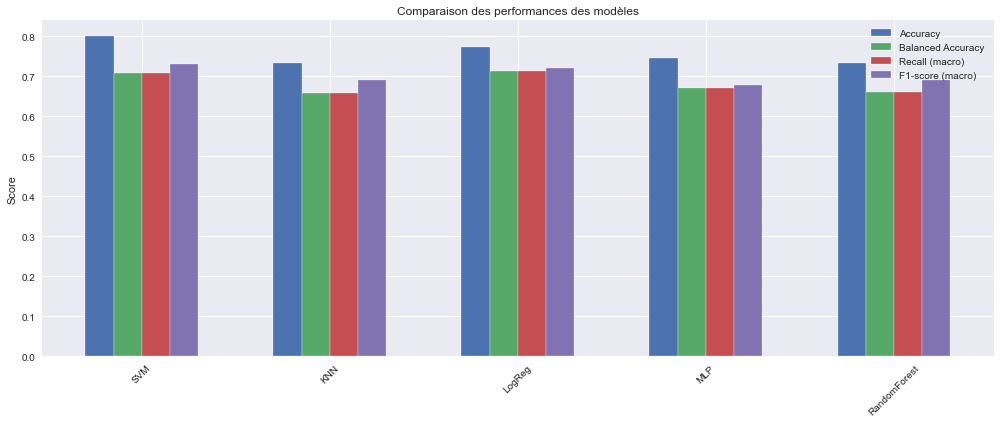


=== RUNNING TUNED MODELS ===

--- Tuning SVM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(104.64656587639881), 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': np.float64(0.002641912674409519), 'kernel': 'rbf'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning KNN ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(4.5705630998014515), 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning MLP ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters fr

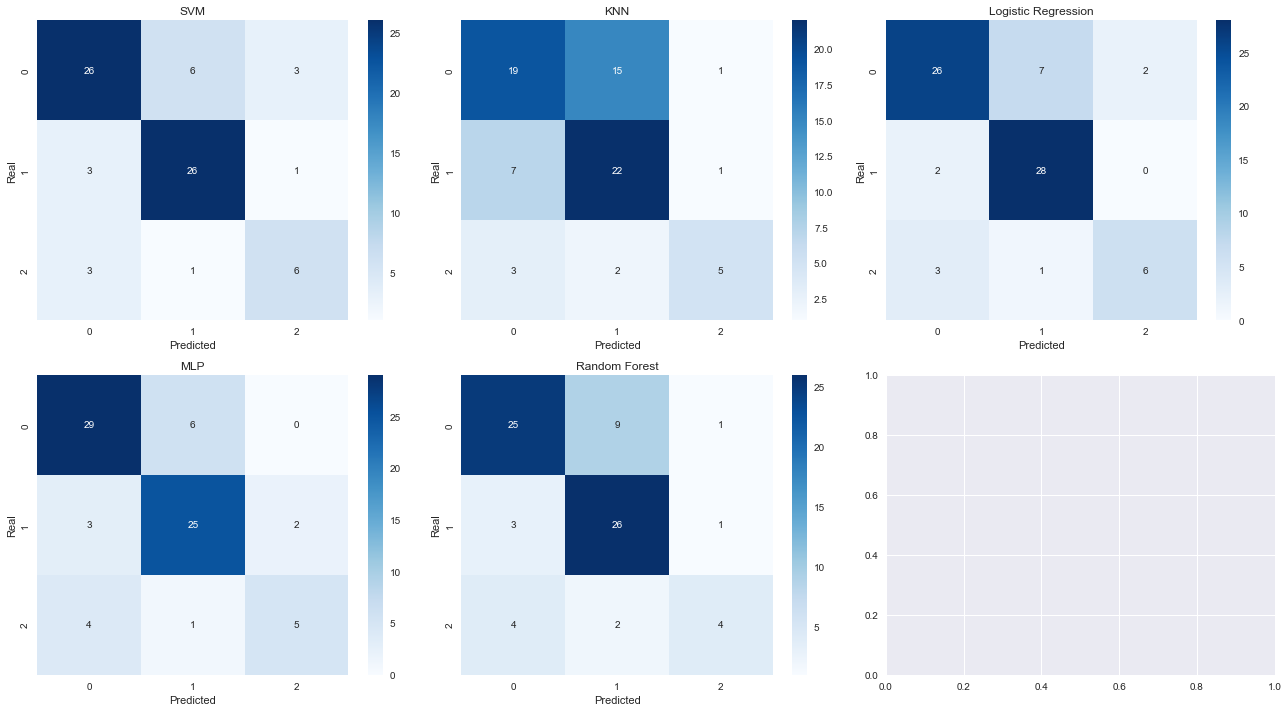

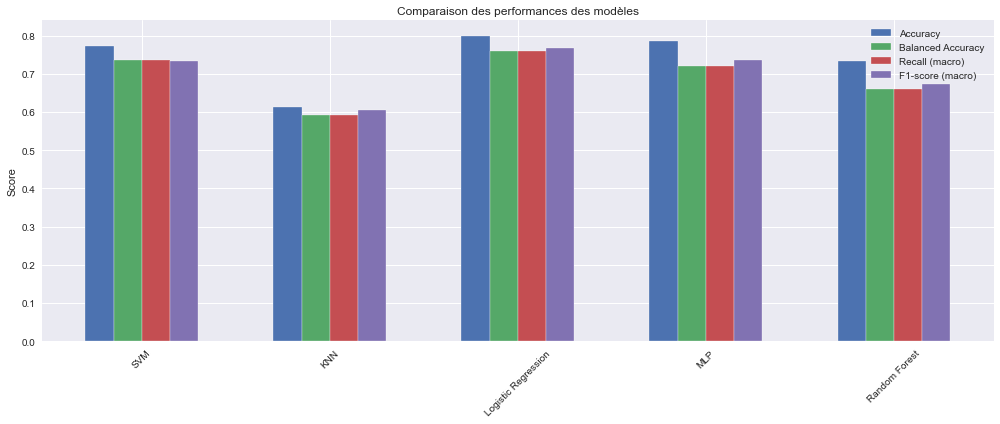


=== Finished running ML for Feature Set 5 - Targeted Class : reduced_bug_type - 249 feats ===

=== RUNNING MACHINE LEARNING MODELS FOR species WITH 25 FEATURES ===

=== RUNNING CLUSTERING METHODS ===

--- RUNNING K-Means Clustering ...
K-Means Silhouette Score: 0.086

--- RUNNING DBSCAN Clustering ...
DBSCAN - Estimated clusters: 1
DBSCAN - Noise points: 20

--- RUNNING Hierarchical Clustering ...
Hierarchical Silhouette Score: 0.105


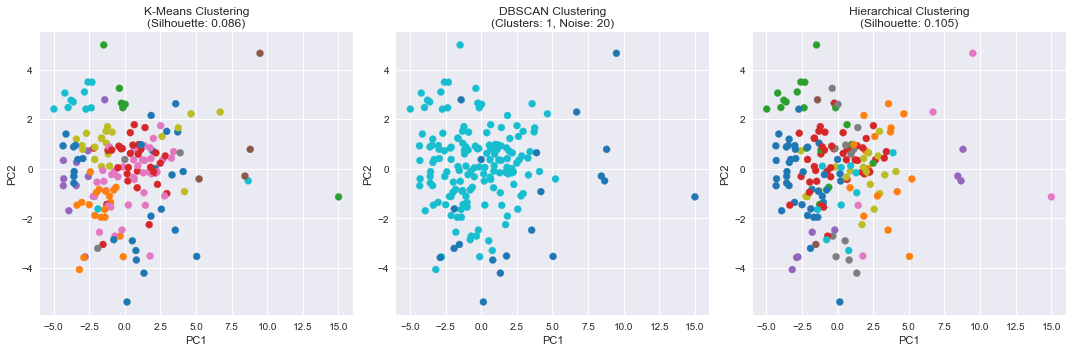


--- RUNNING SVM Classifier ...

--- RUNNING KNN Classifier ...

--- RUNNING Logistic Regression ...

--- RUNNING MLP Classifier ...

--- RUNNING Random Forest Classifier ...


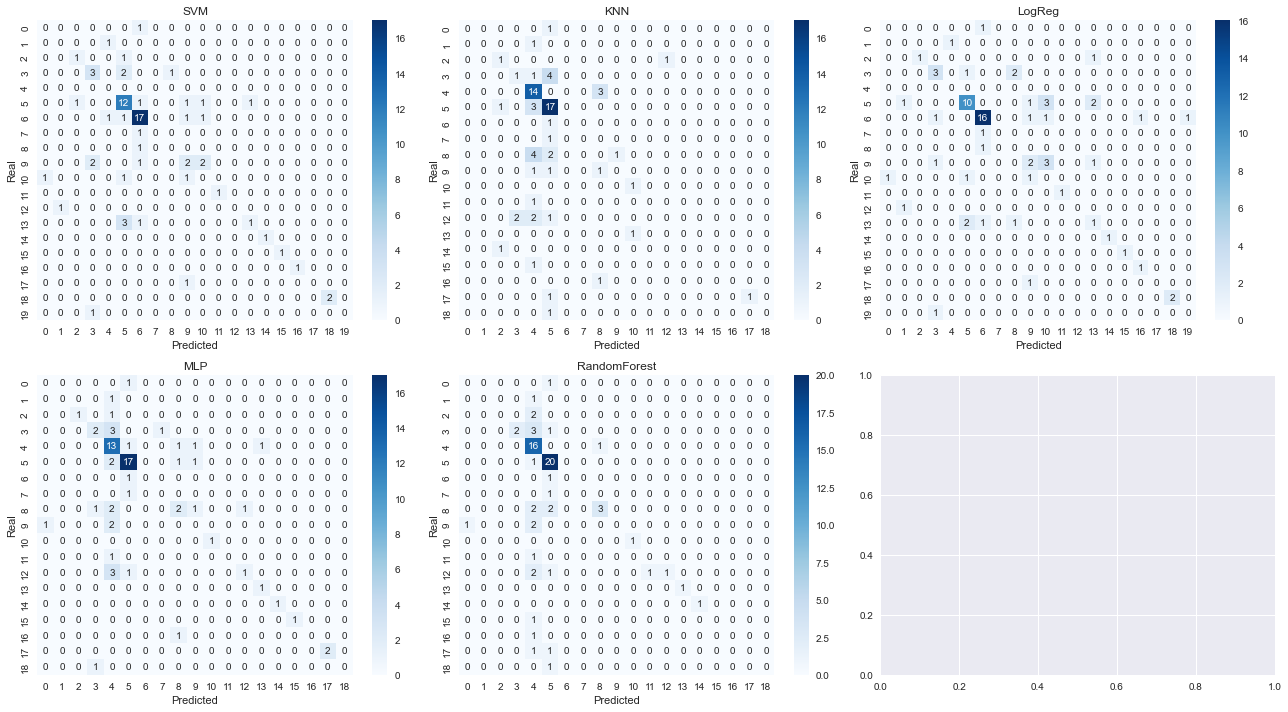

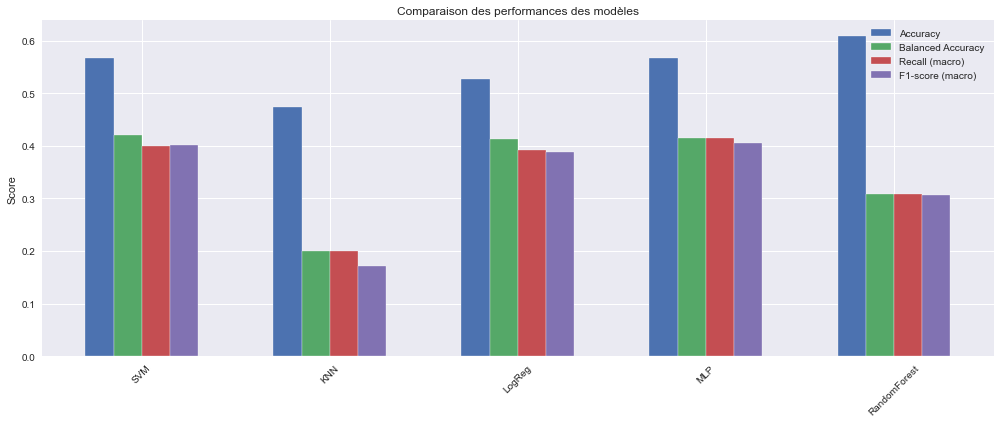


=== RUNNING TUNED MODELS ===

--- Tuning SVM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(28.28484499495253), 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': np.float64(0.007555064367977083), 'kernel': 'rbf'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning KNN ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(27.293781650374736), 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning MLP ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters fro

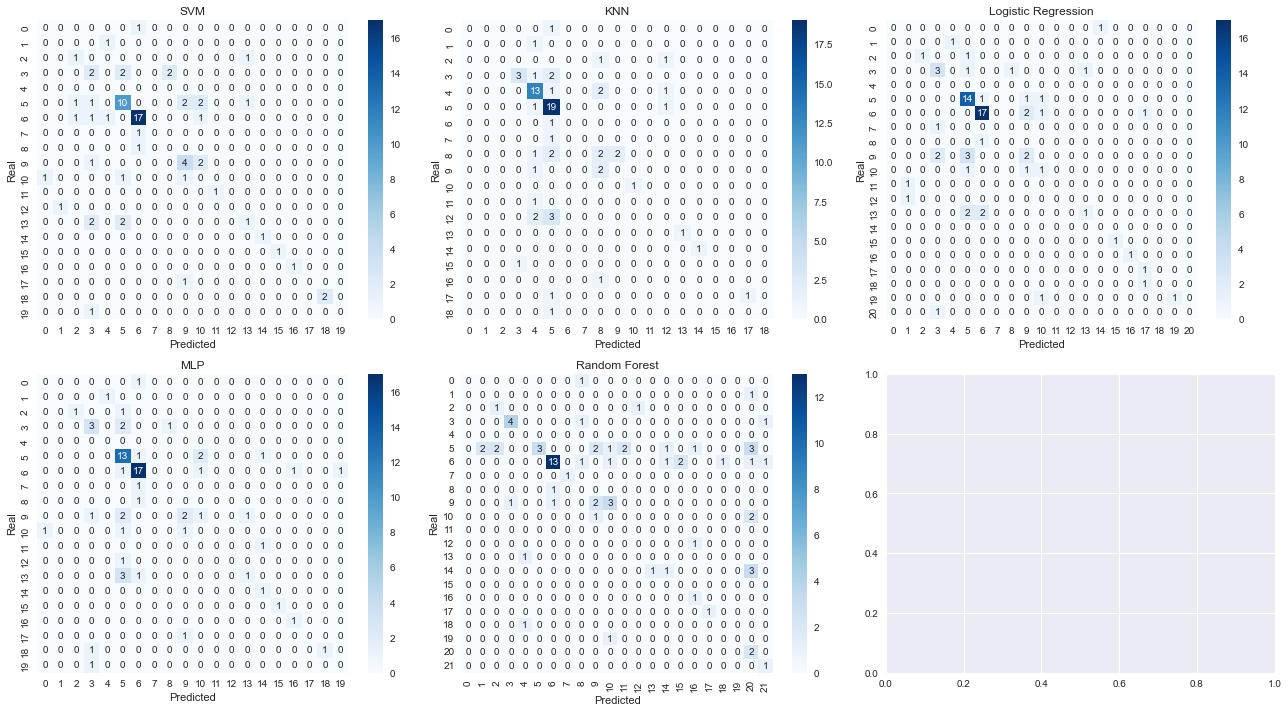

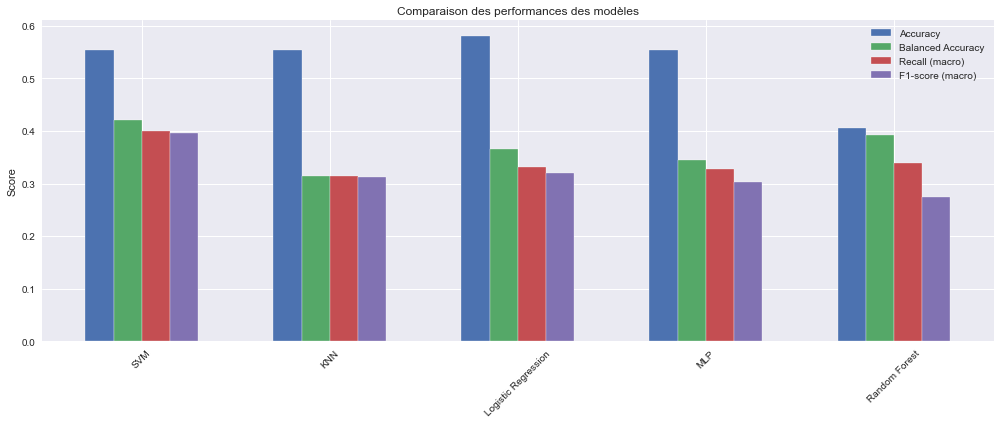


=== Finished running ML for Feature Set 6 - Targeted Class : species - 249 feats ===

=== RUNNING MACHINE LEARNING MODELS FOR bug_type WITH 12 FEATURES ===

=== RUNNING CLUSTERING METHODS ===

--- RUNNING K-Means Clustering ...
K-Means Silhouette Score: 0.137

--- RUNNING DBSCAN Clustering ...
DBSCAN - Estimated clusters: 1
DBSCAN - Noise points: 4

--- RUNNING Hierarchical Clustering ...
Hierarchical Silhouette Score: 0.116


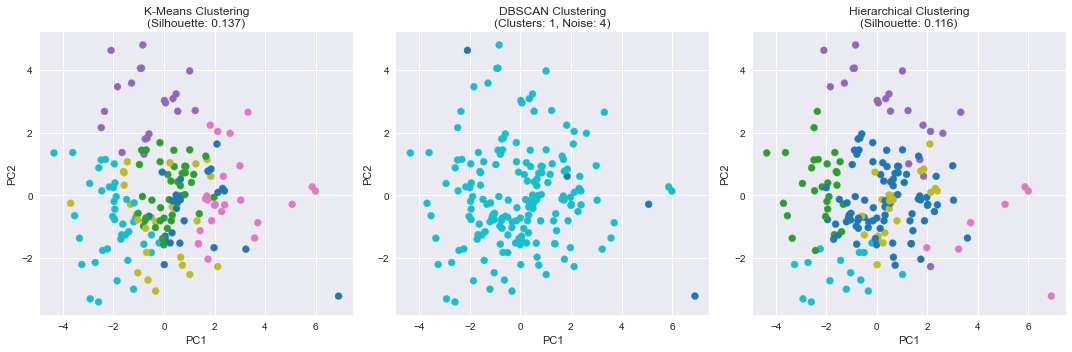


--- RUNNING SVM Classifier ...

--- RUNNING KNN Classifier ...

--- RUNNING Logistic Regression ...

--- RUNNING MLP Classifier ...

--- RUNNING Random Forest Classifier ...


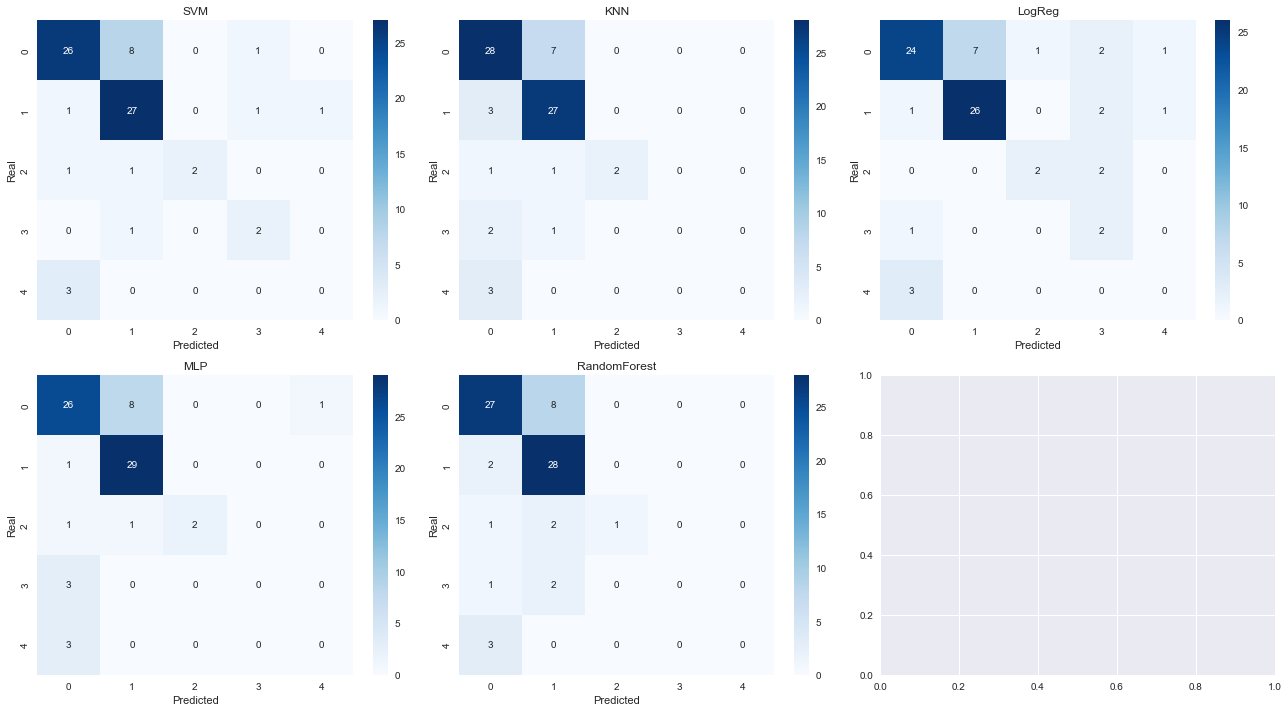

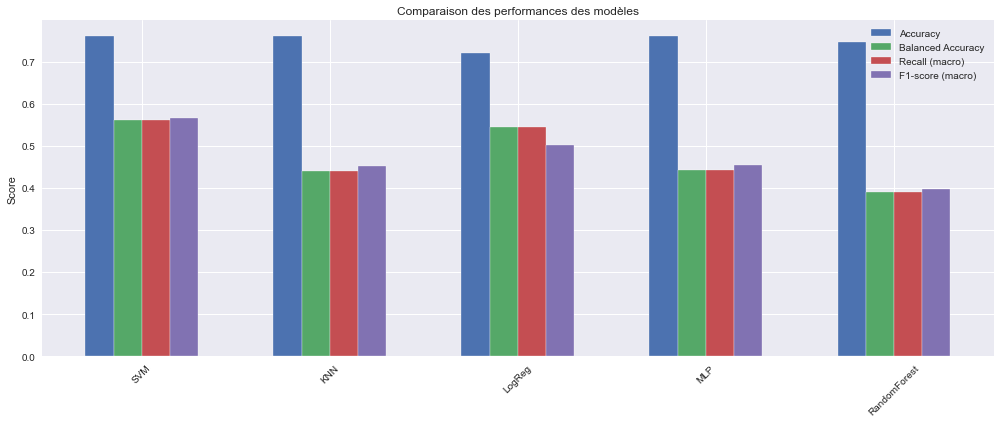


=== RUNNING TUNED MODELS ===

--- Tuning SVM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(88.13049874792026), 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': np.float64(0.04961769101112702), 'kernel': 'rbf'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning KNN ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(49.830438374949125), 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning MLP ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from Ran

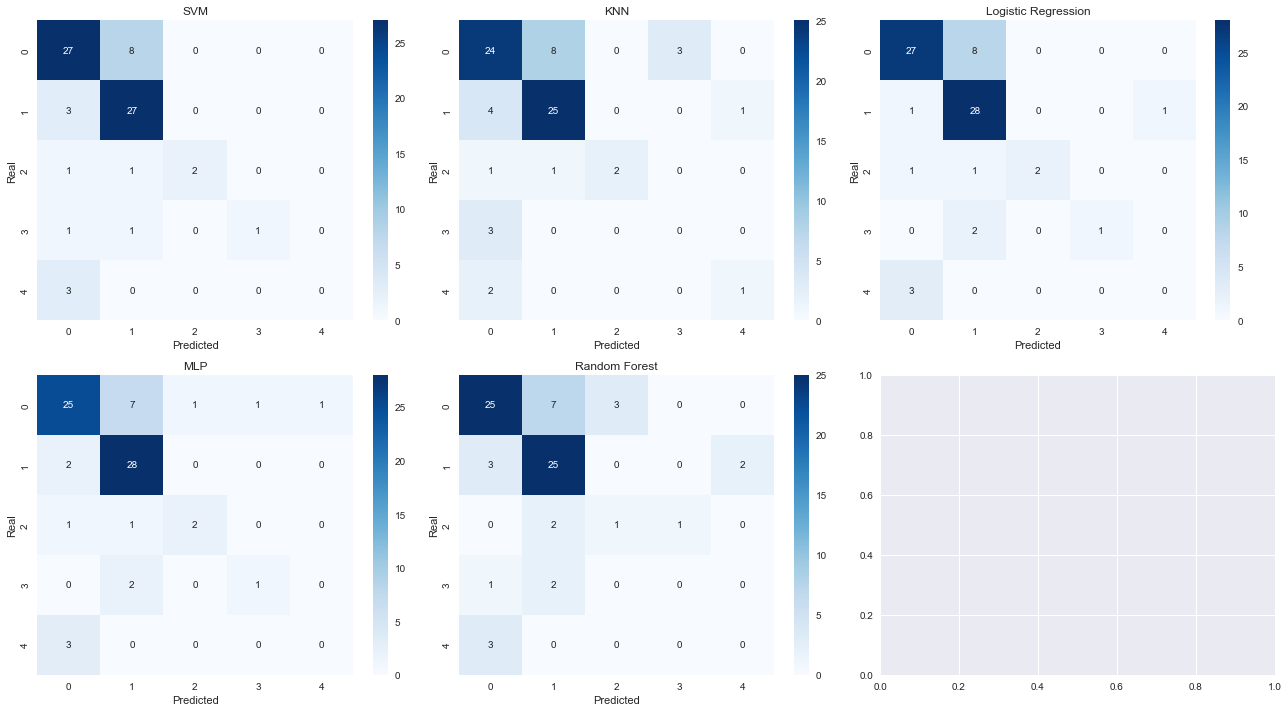

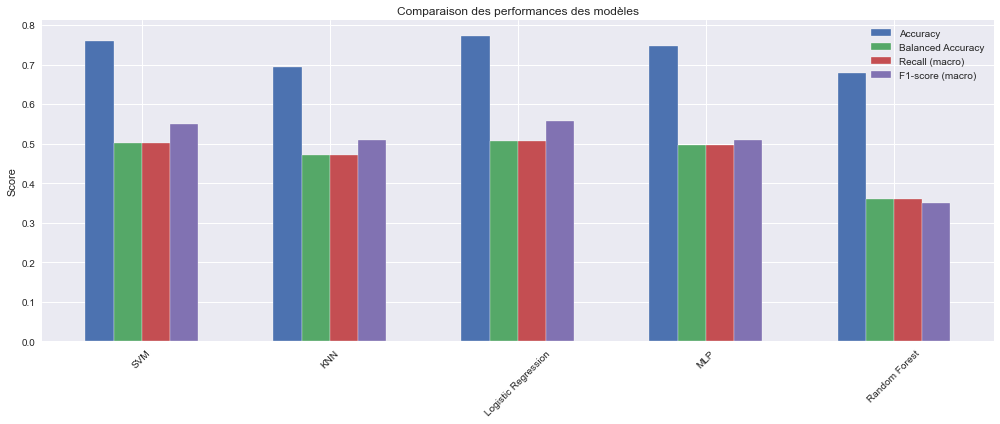


=== Finished running ML for Feature Set 7 - Targeted Class : bug_type - 249 feats ===

=== RUNNING MACHINE LEARNING MODELS FOR reduced_bug_type WITH 12 FEATURES ===

=== RUNNING CLUSTERING METHODS ===

--- RUNNING K-Means Clustering ...
K-Means Silhouette Score: 0.173

--- RUNNING DBSCAN Clustering ...
DBSCAN - Estimated clusters: 1
DBSCAN - Noise points: 2

--- RUNNING Hierarchical Clustering ...
Hierarchical Silhouette Score: 0.129


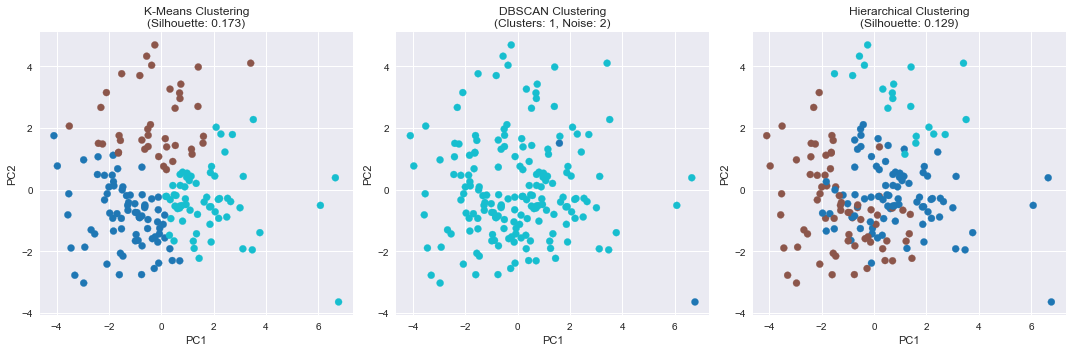


--- RUNNING SVM Classifier ...

--- RUNNING KNN Classifier ...

--- RUNNING Logistic Regression ...

--- RUNNING MLP Classifier ...

--- RUNNING Random Forest Classifier ...


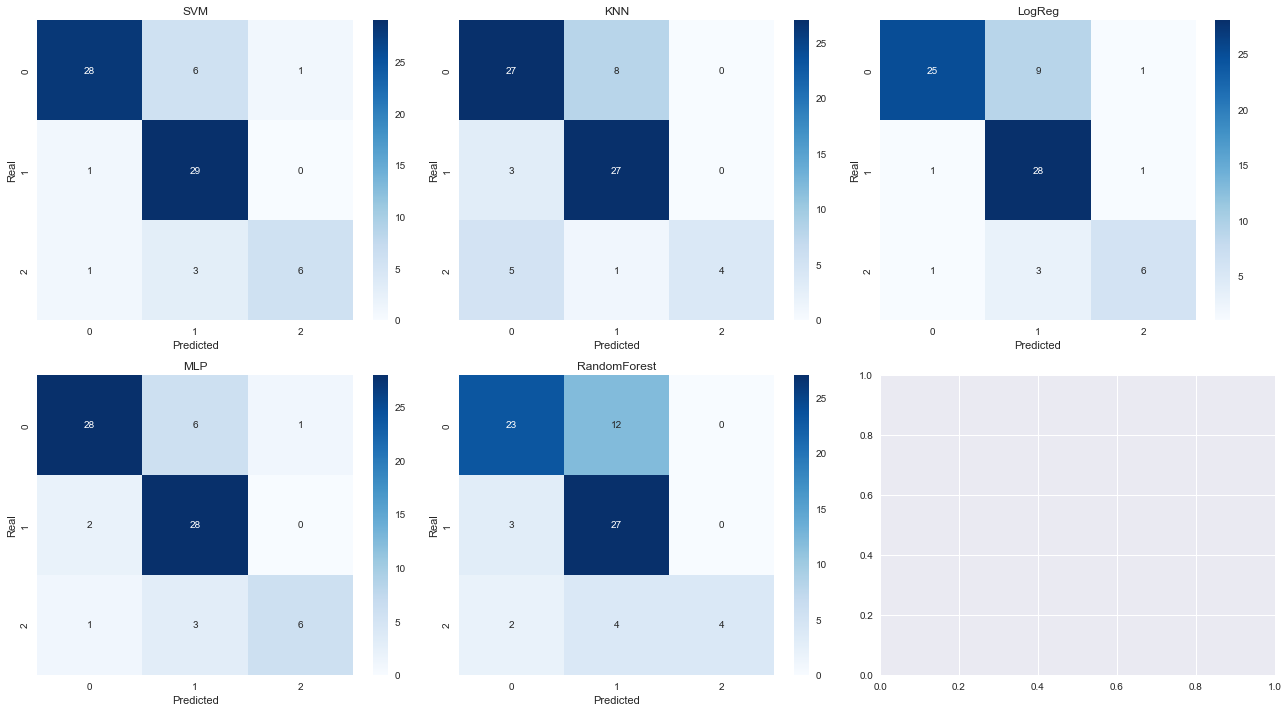

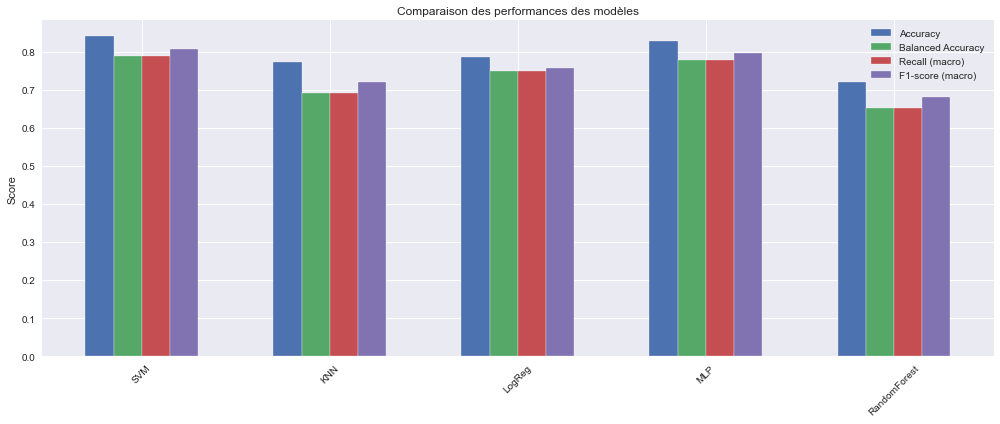


=== RUNNING TUNED MODELS ===

--- Tuning SVM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(124.75962536551158), 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': np.float64(0.0064558350286023644), 'kernel': 'rbf'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning KNN ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(2.6373339933815254), 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning MLP ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from Randomi

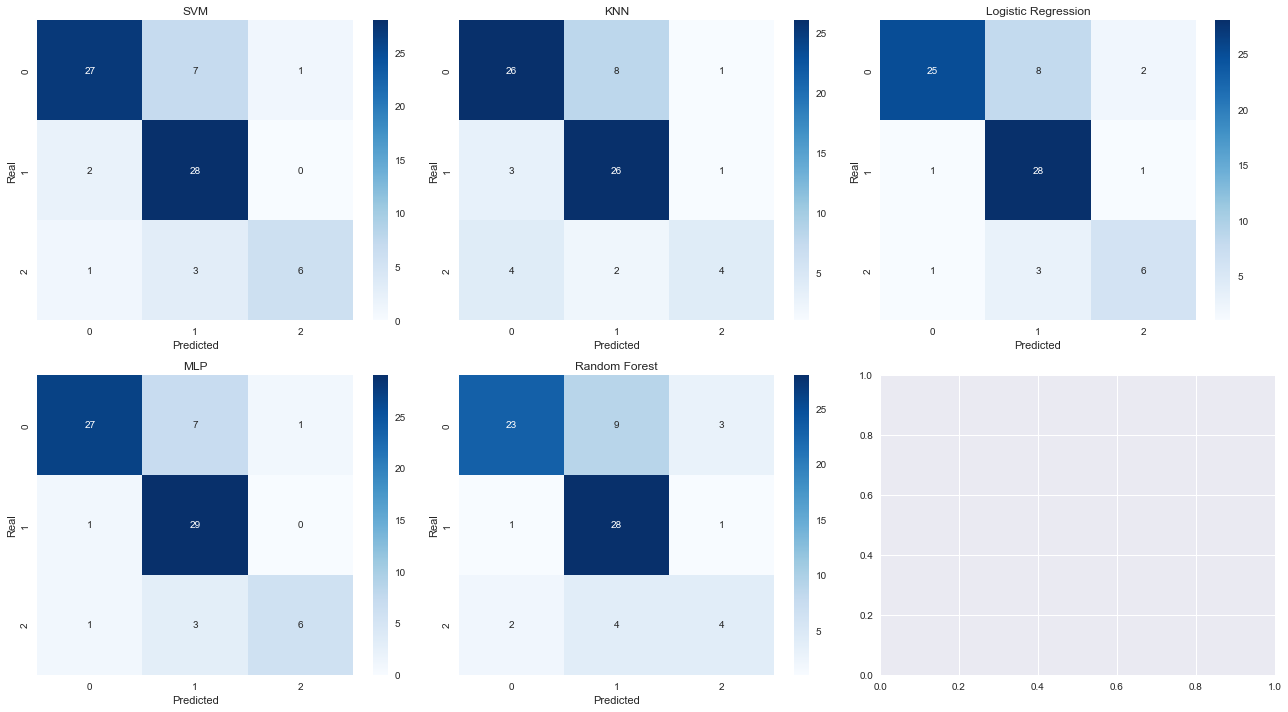

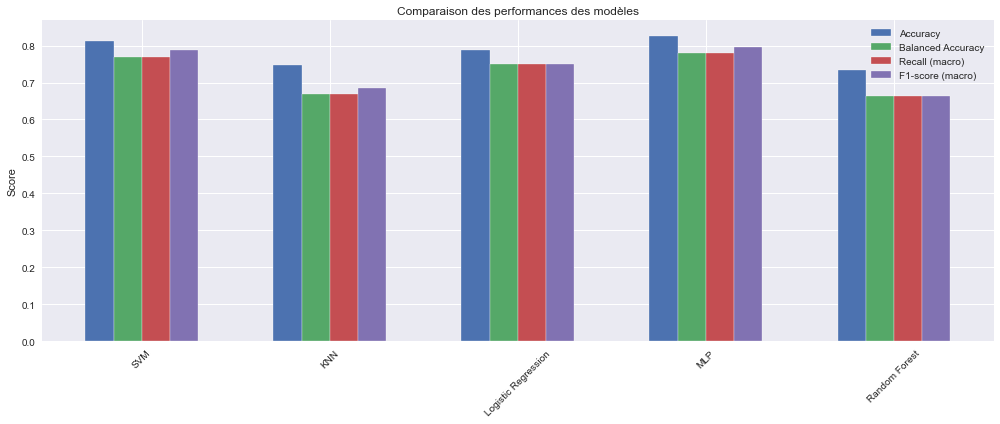


=== Finished running ML for Feature Set 8 - Targeted Class : reduced_bug_type - 249 feats ===

=== RUNNING MACHINE LEARNING MODELS FOR species WITH 12 FEATURES ===

=== RUNNING CLUSTERING METHODS ===

--- RUNNING K-Means Clustering ...
K-Means Silhouette Score: 0.128

--- RUNNING DBSCAN Clustering ...
DBSCAN - Estimated clusters: 1
DBSCAN - Noise points: 4

--- RUNNING Hierarchical Clustering ...
Hierarchical Silhouette Score: 0.133


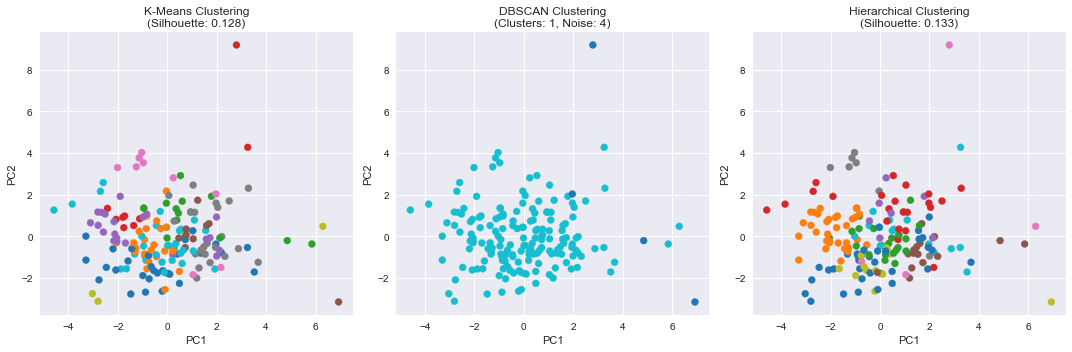


--- RUNNING SVM Classifier ...

--- RUNNING KNN Classifier ...

--- RUNNING Logistic Regression ...

--- RUNNING MLP Classifier ...

--- RUNNING Random Forest Classifier ...


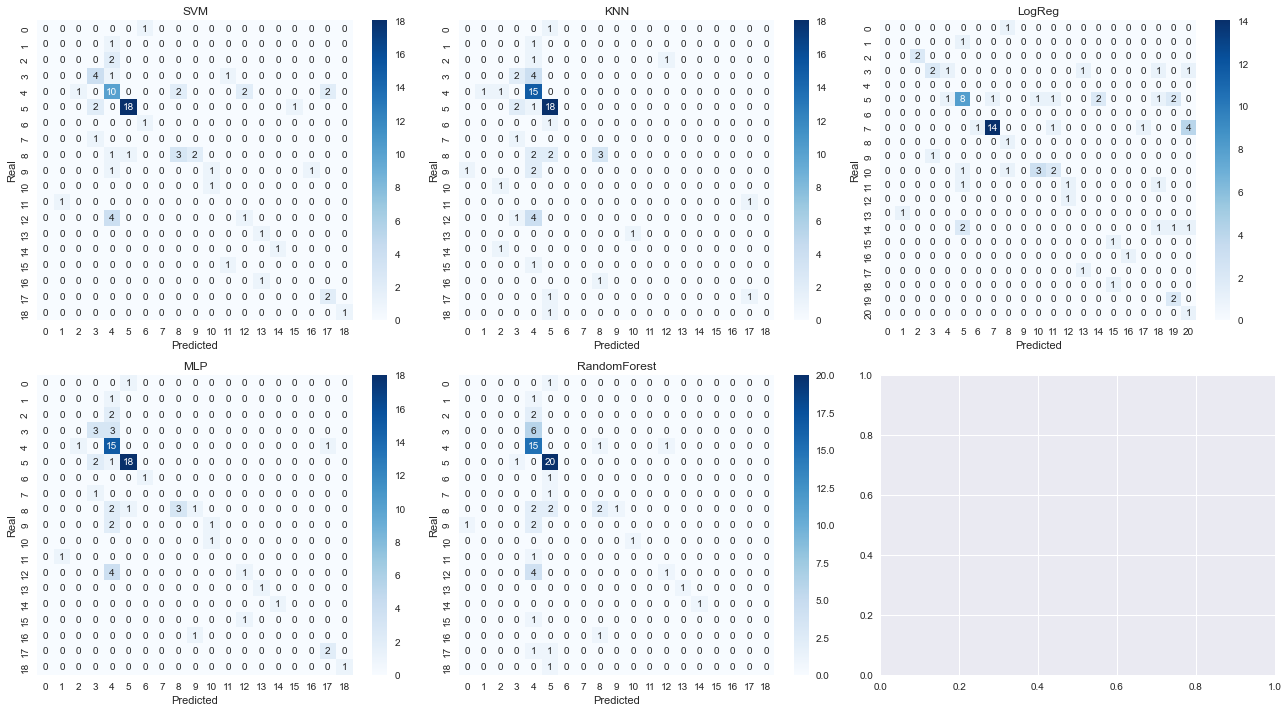

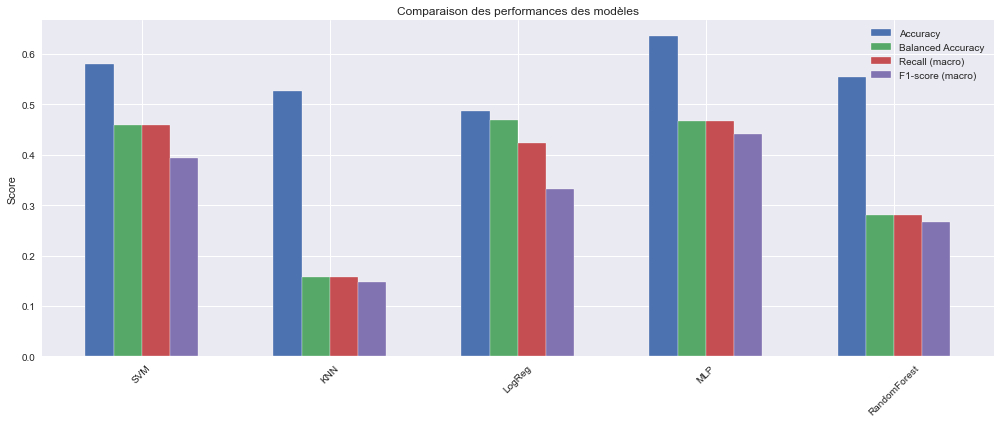


=== RUNNING TUNED MODELS ===

--- Tuning SVM ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(119.83169683940731), 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': np.float64(0.015699452033620265), 'kernel': 'rbf'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning KNN ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters from RandomizedSearchCV: {'C': np.float64(27.293781650374736), 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Tuning MLP ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters fr

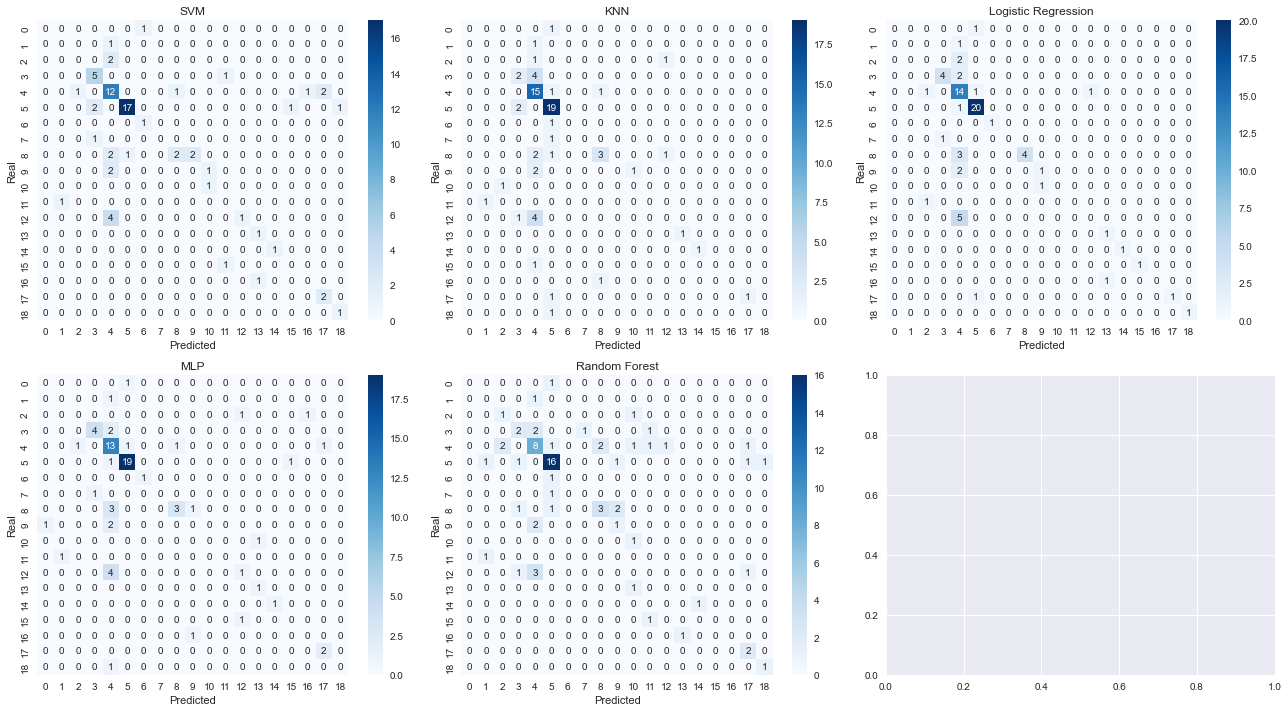

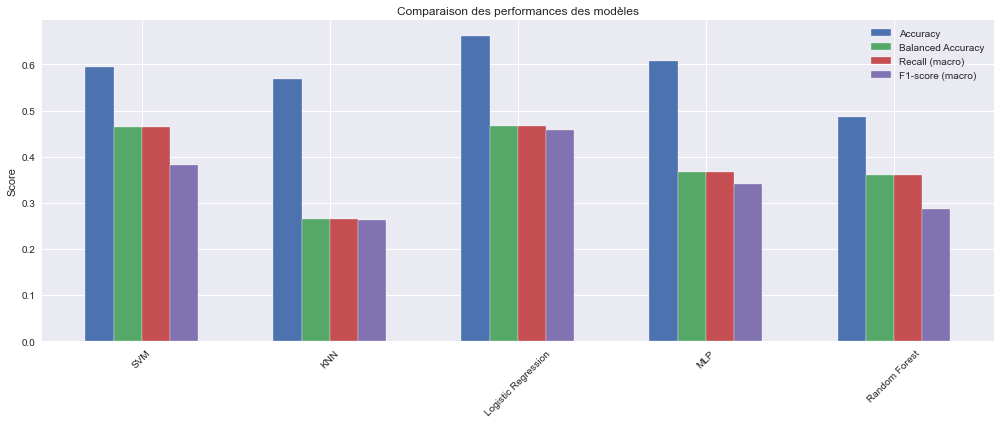


=== Finished running ML for Feature Set 9 - Targeted Class : species - 249 feats ===


In [47]:
# Creating features and classes pairs and run models on those
features_sets = [X, X_filtered, X_filtered_2]
taget_classes = [y, y2, y3]
results_dict = {}
for i, (X_set, y_set) in enumerate([(s, t) for s in features_sets for t in taget_classes]):
    ml_results = run_ml(X_set, y_set)
    print(f"\n=== Finished running ML for Feature Set {i+1} - Targeted Class : {y_set.name} - {X_set.shape[0]} feats ===")
    results_dict[f'feature_set_{i+1}_{y_set.name}_{X_set.shape[0]}_feats'] = ml_results


<h3>7. Saving best model

<font color='yellow'><h5>a) Selecting best model

In [ ]:
best_X = None
best_y = None
best_model = None
best_model_name = None
best_model_scaler = None
best_model_le = None

<font color='yellow'><h5>b) Saving best model

In [ ]:
import pickle

preprocessing_objects = {
    'feature_columns': best_X,
    "target_classes":best_y.name,
    'best_model': best_model,
    'best_model_name': best_model_name,
    "scaler": best_model_scaler,
    'label_encoder': best_model_le
}

with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print("Preprocessing objects saved for test data processing")

<h3>8. Prepare for test data processing

In [96]:
def process_test_images():
    """Process test images and generate predictions"""
    test_results = []
    with open('preprocessing_objects.pkl', 'rb') as f:
        obj = pickle.load(f)

    model = obj['best_model']
    feature_cols = obj['feature_columns']
    target_name = obj['target_classes']
    model_name = obj['best_model_name']
    scaler_ml = obj['scaler']
    le = obj['label_encoder']
    
    # Assuming test images are numbered 251-347
    for img_id in range(251, 348):
        img_path = os.path.join(test_image_dir, f"{img_id}.JPG")
        mask_path = os.path.join(test_mask_dir, f"binary_{img_id}.tif")
        
        if os.path.exists(img_path) and os.path.exists(mask_path):
            # Extract features
            features = extract_comprehensive_features(img_path, mask_path, img_id)
            if features is not None:
                # Remove non-feature columns
                feature_vector = [features.get(col, 0) for col in feature_cols]
                
                # Scale features using the same scaler
                if model_name in ['SVM', 'SVM (Optimized)', 'KNN']:
                    feature_vector_scaled = scaler_ml.transform([feature_vector])
                    prediction = model.predict(feature_vector_scaled)[0]
                else:
                    prediction = model.predict([feature_vector])[0]
                    
                if le:
                    readable_prediction = le.inverse_transform([prediction])[0]
                else:
                    readable_prediction = prediction  # brut si pas de label_encoder
                
                test_results.append({'ID': img_id, target_name: prediction})
    
    return test_results

<h3> Summary

In [ ]:
print("\n=== PROJECT SUMMARY ===")
print(f"✓ Feature extraction completed: {len(feature_cols)} features")
print(f"✓ Data visualization: Distributions, PCA, t-SNE, {'UMAP' if has_umap else 'Isomap'}")
print(f"✓ Supervised methods: SVM, KNN")
print(f"✓ Ensemble method: Random Forest")
print(f"✓ Clustering methods: K-Means, DBSCAN, Hierarchical")
print(f"✓ Hyperparameter optimization: Grid Search (SVM), Randomized Search (RF)")
print(f"✓ Best model selected: {best_model_name}")